# Menu <a class="anchor" id="menu"></a>
   
* [1. Préparatifs](#init)
* [2. Modèle de référence](#ref)
* [3. Augmentation des données](#data_augmentation)
  * [3.1 Augmentations manuelles #1](#data_augmentation_1)
  * [3.2 Augmentations manuelles #2](#data_augmentation_2)
  * [3.3 Augmentations automatique #1](#data_augmentation_auto_1)
  * [Résulats](#data_augmentation_results)
* [4. Recherche d'une meilleure fonction de perte](#loss)
  * [4.1 `Dice`](#loss_dice)
  * [4.2 `Weighted Dice`](#loss_dice2)
  * [4.3 `FocalLoss` w. gamma=0.5](#loss_focal)
  * [4.4 `FocalLoss` w. gamma=1.0](#loss_focal2)
  * [4.5 `Mix` Categorical_Cross_Entropy + Dice (0.5+0.5)](#loss_mix)
  * [4.6 `Mix` Categorical_Cross_Entropy + Dice (0.5+1.0)](#loss_mix2)
  * [Résulats](#loss_results)
* [5. Recherche d'une meilleure architecture](#archi)
  * [5.1 `U-Net` sur un backbone `resnet152`](#archi1)
  * [5.2 `U-Net` sur un backbone `vgg19`](#archi2)
  * [5.3 `U-Net` sur un backbone `resnext101`](#archi3)
  * [5.4 `FPN` sur un backbone `resnet152`](#archi4)
  * [5.5 `FPN` sur un backbone `efficientnetb7`](#archi5)
  * [5.6 `FPN` sur un backbone `vgg19`](#archi6)
  * [5.7 `U-Net` custom](#archi7)
  * [5.8 `LinkNet` sur un backbone `resnet152`](#archi8)
  * [5.9 `LinkNet` sur un backbone `efficientnetb7`](#archi9)
  * [Résulats](#archi_results)

---
---
# 1. Préparatifs pour de la classification avec des Transformers <a class="anchor" id="init"></a> [⇪](#menu)

In [2]:
import time
import glob
import math
import pathlib
import datetime

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import albumentations as A
import segmentation_models as sm
import tensorflow as tf
from tensorflow import keras
from keras import layers

# set random seed for reproductibility
random_seed = 0
np.random.seed(random_seed)

try:
    keras.utils.set_random_seed(random_seed)
except Exception:
    tf.random.set_seed(random_seed)

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-17f93eb1-53fd-c0d2-9e79-19bf9d44983a)


### Allocate only the required memory (so that we can run other notebooks at the same time if needed...

In [8]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Fonctions communes

In [9]:
def summarize_diagnostics(history):
    
    figure = plt.figure(figsize=(8,8))
            
    # plot loss
    plt.subplot(211)
    plt.title(f_loss.name.title())
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    
    # plot metric
    plt.subplot(212)
    plt.title('IoU scores')
    plt.plot(history.history['iou_score'], color='blue', label='train')
    plt.plot(history.history['val_iou_score'], color='orange', label='val')
    plt.legend()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()
    
    plt.tight_layout(pad=1.0)
    plt.show()

In [10]:
def compare_segmentations(img_source, mask_source, predictions):
    
    mask = np.argmax(predictions, axis=3)[0]
    
    fig = plt.figure(figsize=(19,10))
    plt.subplot(1,3,1)
    plt.imshow(img_source)
    plt.axis('off')
    plt.title("Source")

    plt.subplot(1,3,2)
    plt.imshow(mask)
    plt.axis('off')
    plt.title("Predicted mask")

    plt.subplot(1,3,3)
    plt.imshow(mask_source)
    plt.axis('off')
    plt.title("Original mask")
    
    plt.tight_layout()
    plt.show()

In [11]:
class Scores():
    
    def __init__(self, cols, save_path=None, load_path=None):
        self.cols = cols
        self.save_path = save_path
        
        if load_path and pathlib.Path.exists(load_path):
            self.scores = pd.read_csv(load_path, index_col=0)
        else:
            self.clear_scores()
        
    def add_scores(self, name, dict_scores):
        self.scores.loc[name] = dict_scores
        self.save_scores()
        
    def show_scores(self, name=None):
        if name:
            display(self.scores.loc[name])
        else:
            display(self.scores)
            
    def save_scores(self):
        if self.save_path:
            self.scores.to_csv(self.save_path)
            
    def clear_scores(self):
        self.scores = pd.DataFrame([], columns=self.cols)
        self.save_scores()
        
scorer = Scores(
    ['IoU', 'Dice', 'training_time', 'inference_time_500', 'inference_time_1'],
    pathlib.Path('logs', 'scores.csv'),
    pathlib.Path('logs', 'scores.csv'),
)

In [12]:
scorer.show_scores()

IoU      Dice  \
U-Net_baseline                                      0.552171  0.667224   
U-Net_baseline_with_data_augmentation_1             0.564558  0.680571   
U-Net_baseline_with_data_augmentation_2             0.559365  0.674603   
U-Net_baseline_with_data_augmentation_3             0.117844  0.197346   
U-Net_baseline_with_data_augmentation_2_diceLoss    0.631681  0.743959   
U-Net_baseline_with_data_augmentation_2_diceLos...  0.612228  0.728071   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.486711  0.612405   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.454141  0.585703   
U-Net_baseline_with_data_augmentation_2_cceDice...  0.622789  0.738499   
U-Net_baseline_with_data_augmentation_2_cceDice...  0.628407  0.742861   
U-Net-resetnet152_with_data_augmentation_2_dice...  0.722085  0.822108   
U-Net-vgg19_with_data_augmentation_2_diceLoss       0.734644  0.832938   
U-Net-resnext101_with_data_augmentation_2_diceLoss  0.720611  0.820914   
FPN-resnet152_with_data_augmentation_2_diceLoss     0.738715  0.834818   
FPN-efficientnetb7_with_data_augmentation_2_dic...  0.768454  0.858004   
FPN-vgg19_with_data_augmentation_2_diceLoss         0.744457  0.839688   
U-Net-custom_with_data_augmentation_2_diceLoss      0.541770  0.657728   
LinkNet-resnet152_with_data_augmentation_2_dice...  0.707575  0.809275   

                                                    training_time  \
U-Net_baseline                                         517.575655   
U-Net_baseline_with_data_augmentation_1               1029.694759   
U-Net_baseline_with_data_augmentation_2                714.297488   
U-Net_baseline_with_data_augmentation_3                284.685457   
U-Net_baseline_with_data_augmentation_2_diceLoss       843.582155   
U-Net_baseline_with_data_augmentation_2_diceLos...     697.217847   
U-Net_baseline_with_data_augmentation_2_focalLo...     326.424069   
U-Net_baseline_with_data_augmentation_2_focalLo...     318.810731   
U-Net_baseline_with_data_augmentation_2_cceDice...     899.124581   
U-Net_baseline_with_data_augmentation_2_cceDice...     995.207425   
U-Net-resetnet152_with_data_augmentation_2_dice...    3538.612212   
U-Net-vgg19_with_data_augmentation_2_diceLoss         1932.282903   
U-Net-resnext101_with_data_augmentation_2_diceLoss    3738.743413   
FPN-resnet152_with_data_augmentation_2_diceLoss       4316.767552   
FPN-efficientnetb7_with_data_augmentation_2_dic...    5930.868126   
FPN-vgg19_with_data_augmentation_2_diceLoss           2601.794258   
U-Net-custom_with_data_augmentation_2_diceLoss         820.391873   
LinkNet-resnet152_with_data_augmentation_2_dice...    2433.885920   

                                                    inference_time_500  \
U-Net_baseline                                                1.851263   
U-Net_baseline_with_data_augmentation_1                       2.369722   
U-Net_baseline_with_data_augmentation_2                       2.345822   
U-Net_baseline_with_data_augmentation_3                       2.193978   
U-Net_baseline_with_data_augmentation_2_diceLoss              2.138717   
U-Net_baseline_with_data_augmentation_2_diceLos...            2.189904   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.646039   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.206589   
U-Net_baseline_with_data_augmentation_2_cceDice...            2.216438   
U-Net_baseline_with_data_augmentation_2_cceDice...            2.260605   
U-Net-resetnet152_with_data_augmentation_2_dice...            6.312516   
U-Net-vgg19_with_data_augmentation_2_diceLoss                 3.101655   
U-Net-resnext101_with_data_augmentation_2_diceLoss            5.380407   
FPN-resnet152_with_data_augmentation_2_diceLoss               5.874191   
FPN-efficientnetb7_with_data_augmentation_2_dic...            7.299468   
FPN-vgg19_with_data_augmentation_2_diceLoss                   5.406630   
U-Net-custom_with_data_augmentation_2_diceLoss                1.998511   
LinkNe

### DataGenerator

In [13]:
class CustomDataGenerator(keras.utils.Sequence):
    # We use Sequence as parent class, because Sequence are a safer way to do multiprocessing.
    # This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.
    
    def __init__(self, datapath, batch_size, augmentation=None, preprocessing=None, shuffle=False, verbose=0, maxbatches=None, *args, **kwargs):
        self.batch_size = batch_size
        self.ids = [x[:-4] for x in glob.glob(f"{datapath}/*[!_labels].png")]
        self.shuffle = shuffle
        self.verbose = verbose
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.maxbatches = maxbatches
        #print(len(self.ids), self.ids)
        
    def __len__(self):
        # returns the number of batches
        if self.maxbatches:
            return min(self.maxbatches, math.ceil(len(self.ids) / self.batch_size))
        else:
            return math.ceil(len(self.ids) / self.batch_size)
    
    def __getitem__(self, index):
        # returns one batch
        
        since = index * self.batch_size
        until = (index+1) * self.batch_size
        batch_ids = self.ids[since:until]
        
        images = []
        labels = []
        for source_id in batch_ids:
            if self.verbose > 0:
                print(source_id)
            
            x = np.array(Image.open(f"{source_id}.png"))            
            y = np.array(Image.open(f"{source_id}_labels.png"))
            
            if self.augmentation:
                augmented = self.augmentation(image=x, mask=y)
                x, y = augmented['image'], augmented['mask']
                
            if self.preprocessing:
                x = self.preprocessing(x)
              
            images.append(x/255.0) # normalize between 0 and 1 at the same time
            #labels.append(y)
            labels.append(keras.utils.to_categorical(y, 8))
         
        return np.array(images, dtype=float), np.array(labels, dtype=float)
        
    def on_epoch_end(self):
        # logics run once at the very beginning and then at the end of each epoch
        if self.shuffle:
            return np.random.shuffle(self.ids) # /!\ Is this really a good idea ????

### Callbacks

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

def init_callbacks(model_name):

    # Define savepoints
    filepath = pathlib.Path("models", f"{model_name}.keras")
    checkpoint = ModelCheckpoint(
        monitor="val_iou_score",
        mode="max",
        filepath=filepath,
        save_best_only=True,
        verbose=1,
    )
    
    # Define TensorBoard logging
    log_dir = f"logs/fit/{model_name}_{datetime.datetime.now().strftime('%Y%m%d-%H%M')}"
    tensorboard = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
    )
    
    # Define Learning-Rate modification conditions
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=4,
        # min_lr=0.001,
        verbose=1,
    )

    # Define EarlyStopping conditions
    es = EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=9,
        min_delta=0.01, 
        restore_best_weights=True, 
        verbose=1,
    )
    
    return [checkpoint, es, reduce_lr, tensorboard]

---
---
# 2. Modèle de référence *(baseline)* <a class="anchor" id="ref"></a> [⇪](#menu)

### Préparons les training et validation sets **sans** data-augmentation

In [17]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=None, # Pas d'augementations pour la baseline
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Définissons notre modèle de référence

In [18]:
# From https://keras.io/examples/vision/oxford_pets_image_segmentation/
def get_model_ref(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [17]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = get_model_ref((128,256), 8)
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [19]:
model_name = "U-Net_baseline"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.6805 - iou_score: 0.3965 - f1-score: 0.5185
Epoch 1: val_iou_score improved from -inf to 0.11330, saving model to models/U-Net_baseline.keras
372/372 [==============================] - 31s 82ms/step - loss: 0.6805 - iou_score: 0.3965 - f1-score: 0.5185 - val_loss: 1.7338 - val_iou_score: 0.1133 - val_f1-score: 0.1829 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.5258 - iou_score: 0.4529 - f1-score: 0.5748
Epoch 2: val_iou_score improved from 0.11330 to 0.42145, saving model to models/U-Net_baseline.keras
372/372 [==============================] - 28s 76ms/step - loss: 0.5258 - iou_score: 0.4529 - f1-score: 0.5748 - val_loss: 0.6314 - val_iou_score: 0.4215 - val_f1-score: 0.5444 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.4797 - iou_score: 0.4760 - f1-score: 0.5969
Epoch 3: val_iou_score improved from 0.42145 to 0.43063, savin

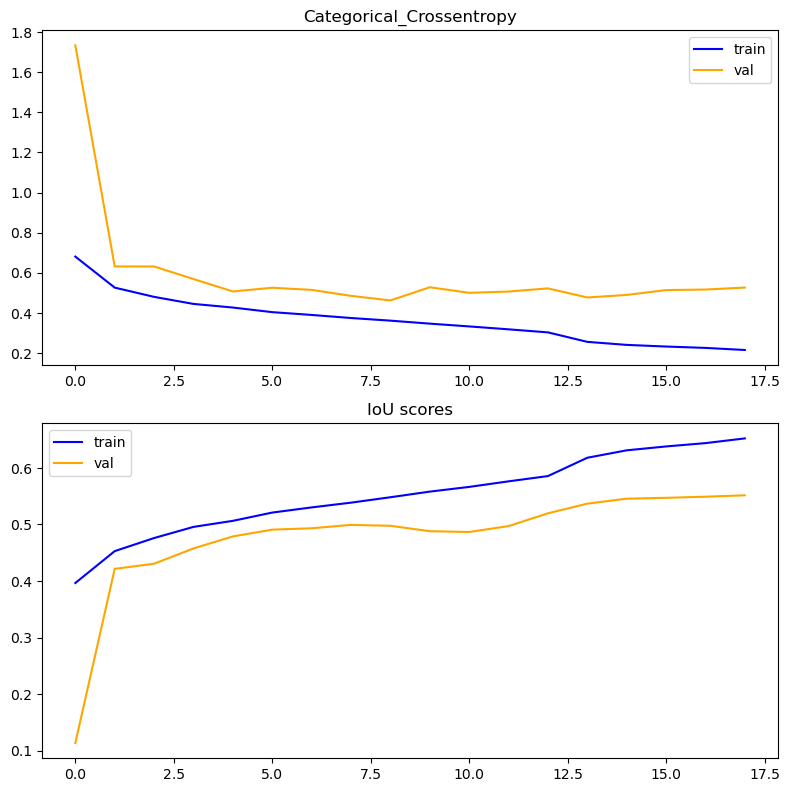

In [20]:
summarize_diagnostics(history)

In [22]:
model = keras.models.load_model(f"models/{model_name}.keras", custom_objects={'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})

In [24]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 2s 28ms/step - loss: 0.5261 - iou_score: 0.5522 - f1-score: 0.6672
inference time (500 samples): 1.85s


### Test de prédiction

In [25]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [26]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 1s 867ms/step
Inference time: 0.90s


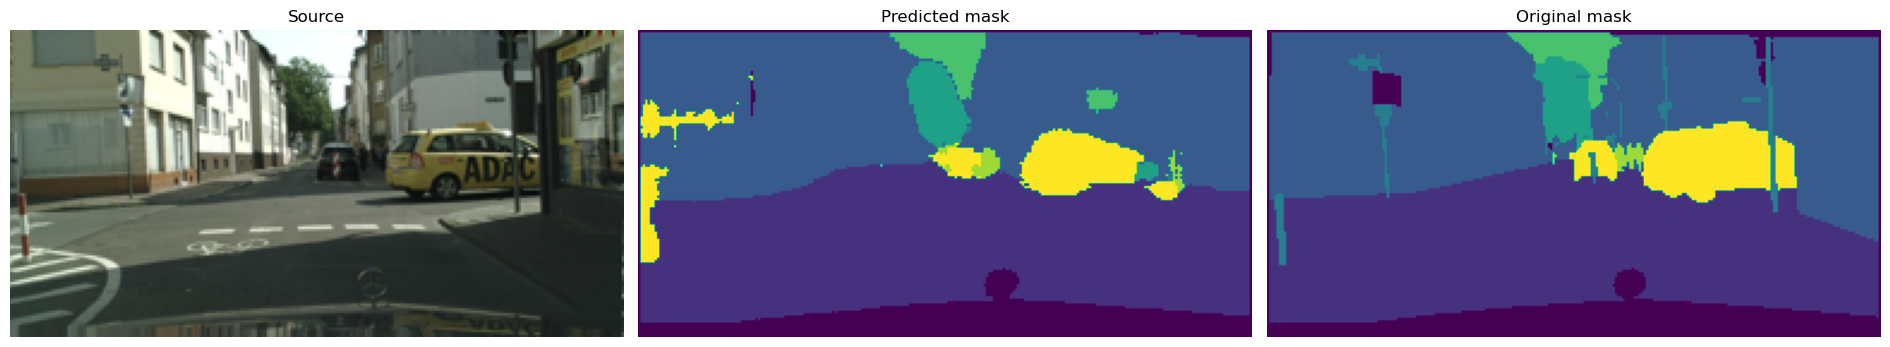

In [27]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [30]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [31]:
scorer.show_scores()

IoU      Dice  training_time  inference_time_500  \
U-Net_baseline  0.552171  0.667224     517.575655            1.851263   

                inference_time_1  
U-Net_baseline          0.895139

---
---
# 3. Augmentation des données <a class="anchor" id="data_augmentation"></a> [⇪](#menu)

## 3.1 Augmentations manuelles #1 <a class="anchor" id="data_augmentation_1"></a> [⇪](#menu)
Pour cette première approche, je vais essayer des combinaisons de transformations qui me semblent logiques

### Préparons les training et validation sets **avec** data-augmentation

In [32]:
transform1 = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(15, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    # A.RandomCrop(width=100, height=100),
    # A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.5),
    # A.Transpose(p=0.5),
    # A.Blur(p=0.01, blur_limit = 3),
    # A.OneOf([
    #        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    #        A.GridDistortion(p=0.5),
    #        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
    # ], p=0.5)
])

In [33]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transform1,
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Gardons le même modèle pour le moment

In [35]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = get_model_ref((128,256), 8)
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [36]:
model_name = "U-Net_baseline_with_data_augmentation_1"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.8646 - iou_score: 0.3436 - f1-score: 0.4652
Epoch 1: val_iou_score improved from -inf to 0.05546, saving model to models/U-Net_baseline_with_data_augmentation_1.keras
372/372 [==============================] - 31s 77ms/step - loss: 0.8646 - iou_score: 0.3436 - f1-score: 0.4652 - val_loss: 2.7226 - val_iou_score: 0.0555 - val_f1-score: 0.0984 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.6252 - iou_score: 0.3963 - f1-score: 0.5210
Epoch 2: val_iou_score improved from 0.05546 to 0.39194, saving model to models/U-Net_baseline_with_data_augmentation_1.keras
372/372 [==============================] - 28s 76ms/step - loss: 0.6252 - iou_score: 0.3963 - f1-score: 0.5210 - val_loss: 0.6193 - val_iou_score: 0.3919 - val_f1-score: 0.5159 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.5772 - iou_score: 0.4189 - f1-score: 0.5440
Epoch 3: val

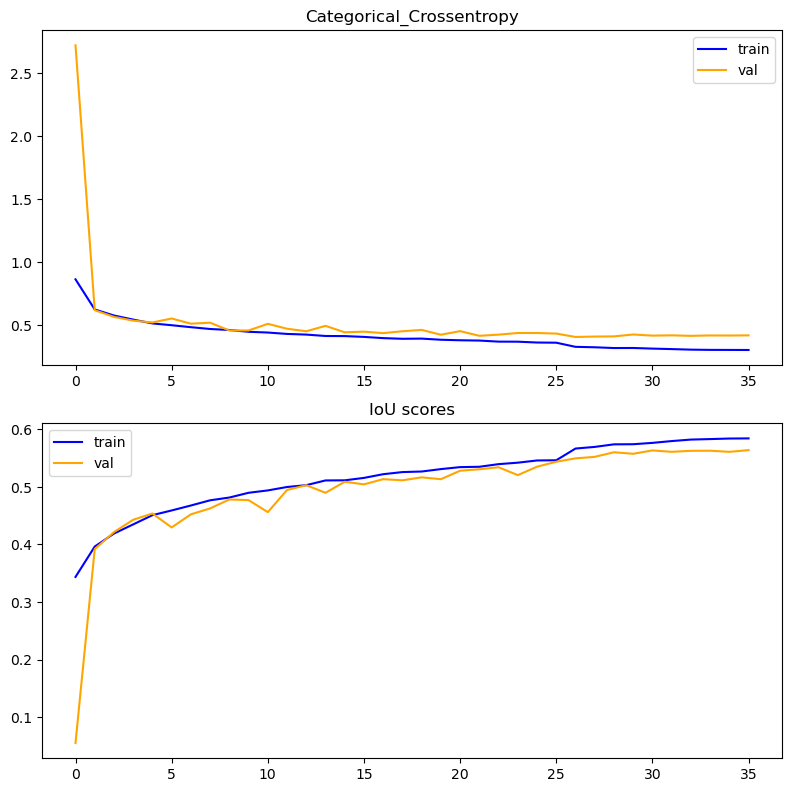

In [37]:
summarize_diagnostics(history)

In [38]:
model = keras.models.load_model(f"models/{model_name}.keras", custom_objects={'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})

In [39]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 2s 28ms/step - loss: 0.4195 - iou_score: 0.5646 - f1-score: 0.6806
inference time (500 samples): 2.37s


### Test de prédiction

In [40]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [41]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 0s 397ms/step
Inference time: 0.42s


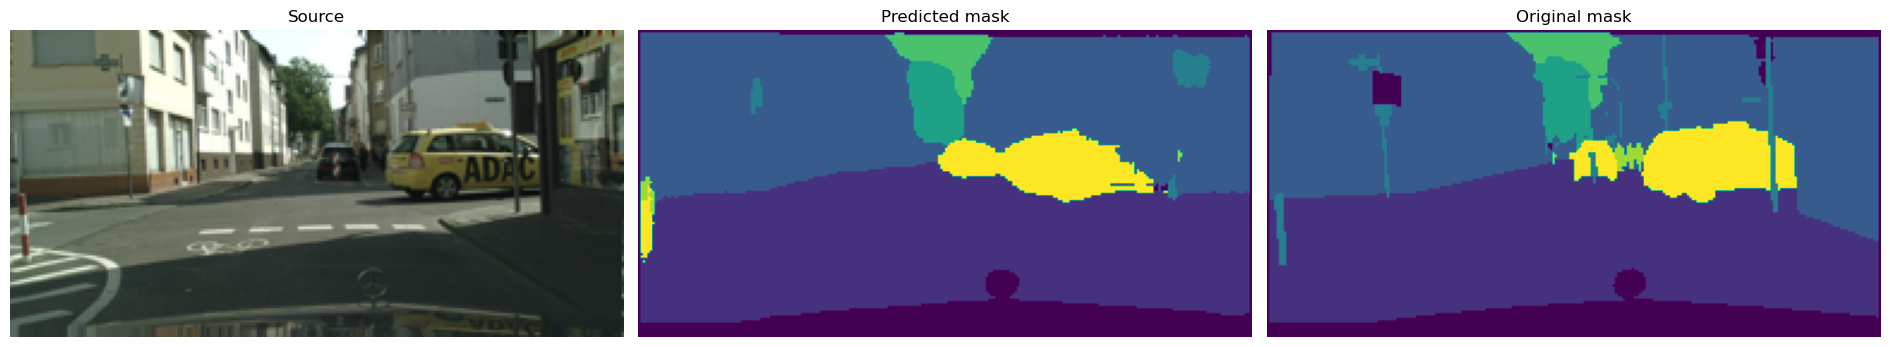

In [42]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [43]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [44]:
scorer.show_scores()

IoU      Dice  training_time  \
U-Net_baseline                           0.552171  0.667224     517.575655   
U-Net_baseline_with_data_augmentation_1  0.564558  0.680571    1029.694759   

                                         inference_time_500  inference_time_1  
U-Net_baseline                                     1.851263          0.895139  
U-Net_baseline_with_data_augmentation_1            2.369722          0.423762

## 3.2 Augmentations manuelles #2 <a class="anchor" id="data_augmentation_2"></a> [⇪](#menu)

Pour cette seconde approche, je vais essayer une autre combinaisons de transformations *(suggérées par mon mentor)*

### Préparons les training et validation sets **avec** data-augmentation

In [15]:
transform2 = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(
            brightness_limit=[-0.2, 0.2],
            contrast_limit=0.2,
            p=0.5,
        ),
        A.RandomGamma(p=0.5),
    ],
    p=0.8,
    ),
])

In [46]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transform2,
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Gardons le même modèle pour le moment

In [47]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = get_model_ref((128,256), 8)
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [48]:
model_name = "U-Net_baseline_with_data_augmentation_2"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.8277 - iou_score: 0.3684 - f1-score: 0.4890
Epoch 1: val_iou_score improved from -inf to 0.07239, saving model to models/U-Net_baseline_with_data_augmentation_2.keras
372/372 [==============================] - 31s 77ms/step - loss: 0.8277 - iou_score: 0.3684 - f1-score: 0.4890 - val_loss: 2.2821 - val_iou_score: 0.0724 - val_f1-score: 0.1242 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.5672 - iou_score: 0.4301 - f1-score: 0.5536
Epoch 2: val_iou_score improved from 0.07239 to 0.39251, saving model to models/U-Net_baseline_with_data_augmentation_2.keras
372/372 [==============================] - 28s 76ms/step - loss: 0.5672 - iou_score: 0.4301 - f1-score: 0.5536 - val_loss: 0.6710 - val_iou_score: 0.3925 - val_f1-score: 0.5170 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.5173 - iou_score: 0.4549 - f1-score: 0.5775
Epoch 3: val

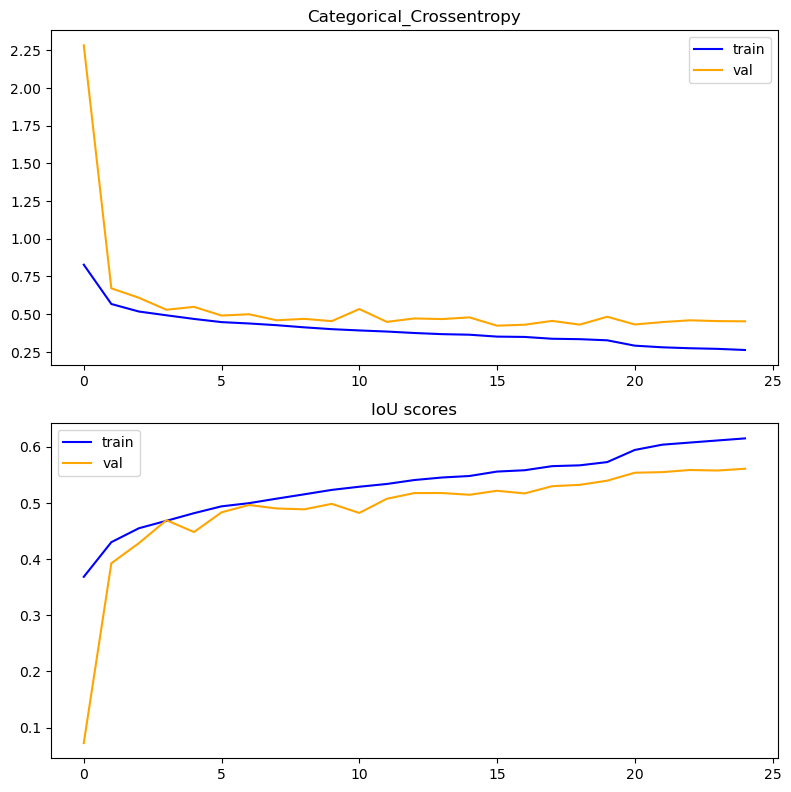

In [49]:
summarize_diagnostics(history)

In [50]:
model = keras.models.load_model(f"models/{model_name}.keras", custom_objects={'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})

In [51]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 2s 28ms/step - loss: 0.4524 - iou_score: 0.5594 - f1-score: 0.6746
inference time (500 samples): 2.35s


### Test de prédiction

In [52]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [53]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 1s 897ms/step
Inference time: 0.92s


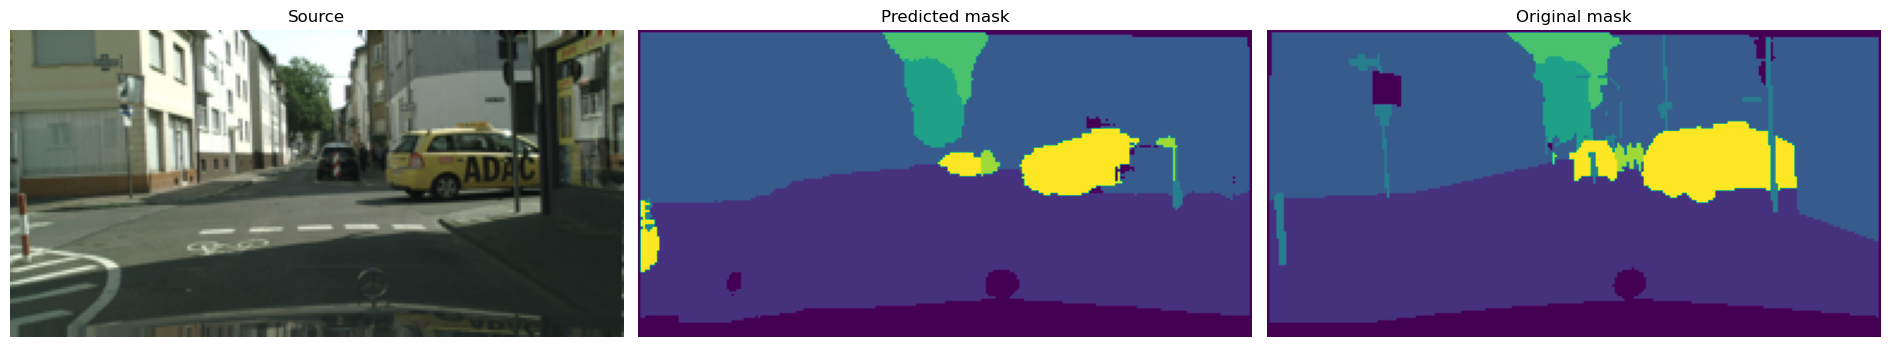

In [54]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [55]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [56]:
scorer.show_scores()

IoU      Dice  training_time  \
U-Net_baseline                           0.552171  0.667224     517.575655   
U-Net_baseline_with_data_augmentation_1  0.564558  0.680571    1029.694759   
U-Net_baseline_with_data_augmentation_2  0.559365  0.674603     714.297488   

                                         inference_time_500  inference_time_1  
U-Net_baseline                                     1.851263          0.895139  
U-Net_baseline_with_data_augmentation_1            2.369722          0.423762  
U-Net_baseline_with_data_augmentation_2            2.345822          0.924520

## 3.3 Augmentations automatique #1 <a class="anchor" id="data_augmentation_auto_1"></a> [⇪](#menu)

Pour ce troisème essai, nous allons utiliser les transformations calculées sur ce même jeu de données avec [AutoAlbument](#https://albumentations.ai/docs/autoalbument/)

AutoAlbument fonctionnant avec pytorch, j'ai préparé un autre dataloader adapté (dans le dossier autoalbument) et entrainé un Unet sur notre jeu de données pour tenter de trouver les transformations optimales. Ensuite le resultat à été stocké dans un fichier policy.json que nous allons charger et utiliser pour la suite.

### Préparons les training et validation sets **avec** data-augmentation

In [57]:
transformAuto = A.load("autoalbument/policy_28.json")

In [58]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transformAuto,
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Gardons le même modèle pour le moment

In [59]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = get_model_ref((128,256), 8)
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [60]:
model_name = "U-Net_baseline_with_data_augmentation_3"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.9609 - iou_score: 0.2984 - f1-score: 0.4178
Epoch 1: val_iou_score improved from -inf to 0.08976, saving model to models/U-Net_baseline_with_data_augmentation_3.keras
372/372 [==============================] - 30s 76ms/step - loss: 0.9609 - iou_score: 0.2984 - f1-score: 0.4178 - val_loss: 1.8713 - val_iou_score: 0.0898 - val_f1-score: 0.1558 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.7015 - iou_score: 0.3596 - f1-score: 0.4848
Epoch 2: val_iou_score did not improve from 0.08976
372/372 [==============================] - 28s 75ms/step - loss: 0.7015 - iou_score: 0.3596 - f1-score: 0.4848 - val_loss: 59.7512 - val_iou_score: 0.0636 - val_f1-score: 0.1134 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.6438 - iou_score: 0.3841 - f1-score: 0.5105
Epoch 3: val_iou_score improved from 0.08976 to 0.10729, saving model to models/U-Net

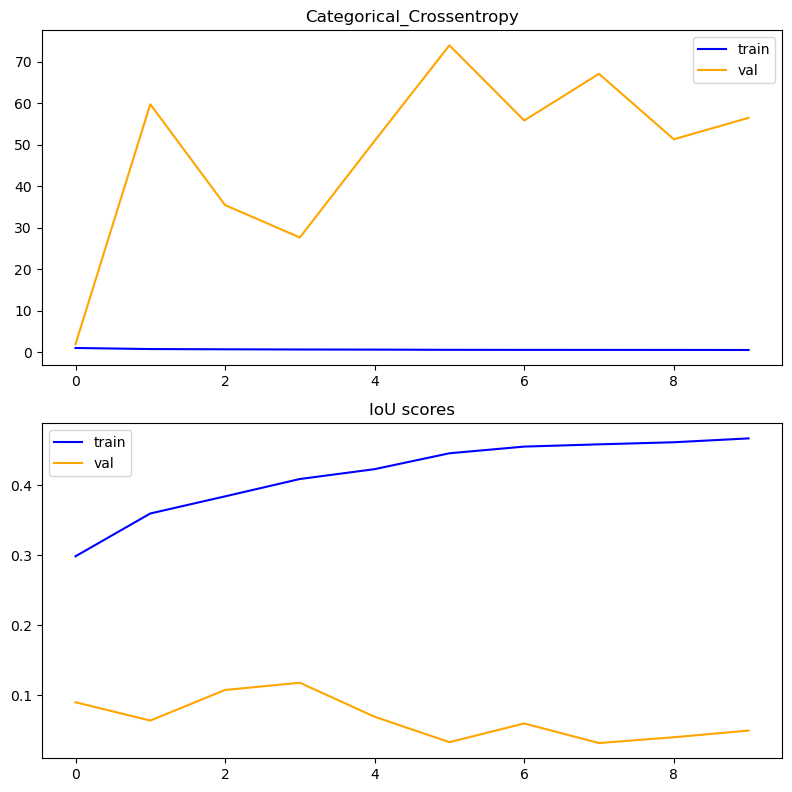

In [61]:
summarize_diagnostics(history)

In [62]:
model = keras.models.load_model(f"models/{model_name}.keras", custom_objects={'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})

In [63]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 2s 26ms/step - loss: 27.6132 - iou_score: 0.1178 - f1-score: 0.1973
inference time (500 samples): 2.19s


### Test de prédiction

In [64]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [65]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 0s 389ms/step
Inference time: 0.41s


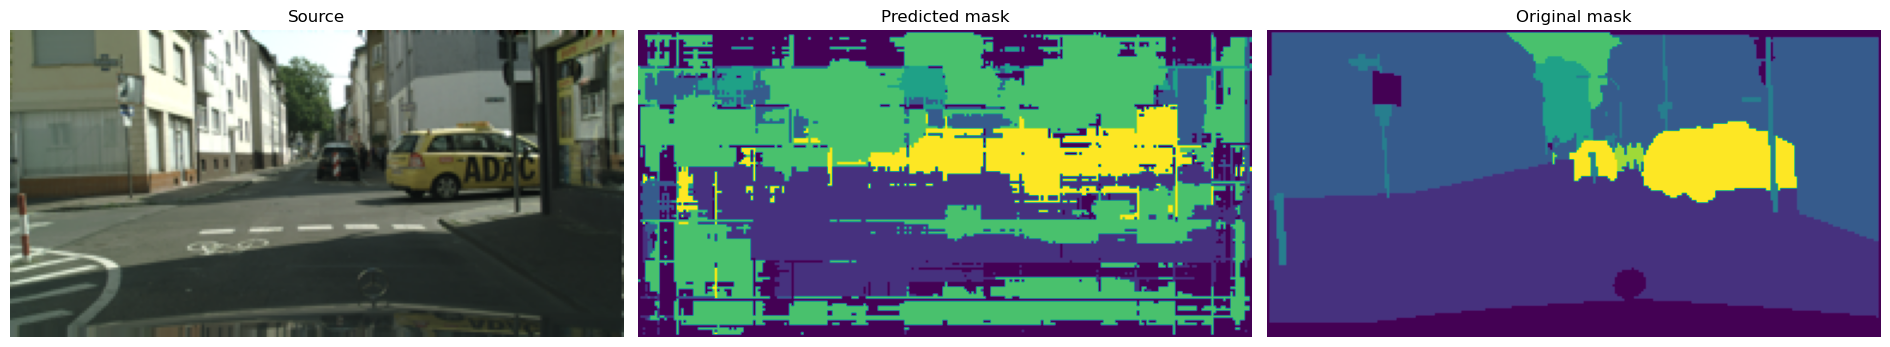

In [66]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [67]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [68]:
scorer.show_scores()

IoU      Dice  training_time  \
U-Net_baseline                           0.552171  0.667224     517.575655   
U-Net_baseline_with_data_augmentation_1  0.564558  0.680571    1029.694759   
U-Net_baseline_with_data_augmentation_2  0.559365  0.674603     714.297488   
U-Net_baseline_with_data_augmentation_3  0.117844  0.197346     284.685457   

                                         inference_time_500  inference_time_1  
U-Net_baseline                                     1.851263          0.895139  
U-Net_baseline_with_data_augmentation_1            2.369722          0.423762  
U-Net_baseline_with_data_augmentation_2            2.345822          0.924520  
U-Net_baseline_with_data_augmentation_3            2.193978          0.414083

> ### Conclusion <a class="anchor" id="data_augmentation_results"></a>
> A ce stade, le meilleur modèle semble être `U-Net_baseline_with_data_augmentation_1` qui surpasse le modèle de référence `U-Net_baseline` et les autres.
>
> Mais `U-Net_baseline_with_data_augmentation_2` obtient également une légère augmentation tout en gardant un temps de training plus bas.... on va donc utiliser cette seconde approche pour minimiser nos coûts d'entrainement...
>
> On note également la contre performance du modèle dont les transformations ont été calculées avec `AutoAlbument`

---
---
# 4. Recherche d'une meilleure fonction de perte <a class="anchor" id="loss"></a> [⇪](#menu)

## 4.1 Utilisation de Dice comme fonction de perte <a class="anchor" id="loss_dice"></a> [⇪](#menu)

### Préparons les training et validation sets **avec** data-augmentation

In [21]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transform2,
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Gardons le même modèle pour le moment

In [37]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = sm.losses.DiceLoss() 
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = get_model_ref((128,256), 8)
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [27]:
model_name = "U-Net_baseline_with_data_augmentation_2_diceLoss"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.4331 - iou_score: 0.4484 - f1-score: 0.5669
Epoch 1: val_iou_score improved from -inf to 0.12267, saving model to models/U-Net_baseline_with_data_augmentation_2_diceLoss.keras
372/372 [==============================] - 32s 86ms/step - loss: 0.4331 - iou_score: 0.4484 - f1-score: 0.5669 - val_loss: 0.8203 - val_iou_score: 0.1227 - val_f1-score: 0.1796 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.3539 - iou_score: 0.5255 - f1-score: 0.6461
Epoch 2: val_iou_score improved from 0.12267 to 0.48494, saving model to models/U-Net_baseline_with_data_augmentation_2_diceLoss.keras
372/372 [==============================] - 29s 77ms/step - loss: 0.3539 - iou_score: 0.5255 - f1-score: 0.6461 - val_loss: 0.3963 - val_iou_score: 0.4849 - val_f1-score: 0.6038 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.3346 - iou_score: 0.5453 - f1-score: 0

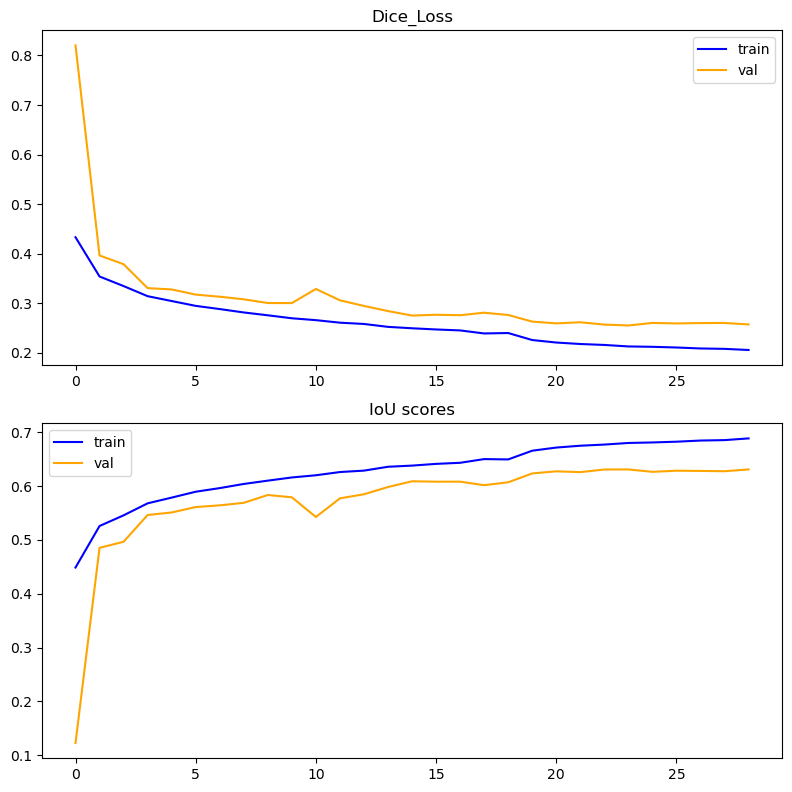

In [28]:
summarize_diagnostics(history)

In [30]:
model = keras.models.load_model(
    f"models/{model_name}.keras", 
    custom_objects={
        'iou_score':sm.metrics.iou_score, 
        'f1-score':sm.metrics.f1_score, 
        'dice_loss':sm.losses.DiceLoss() })

In [31]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 2s 25ms/step - loss: 0.2559 - iou_score: 0.6317 - f1-score: 0.7440
inference time (500 samples): 2.14s


### Test de prédiction

In [32]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [33]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 1s 873ms/step
Inference time: 0.90s


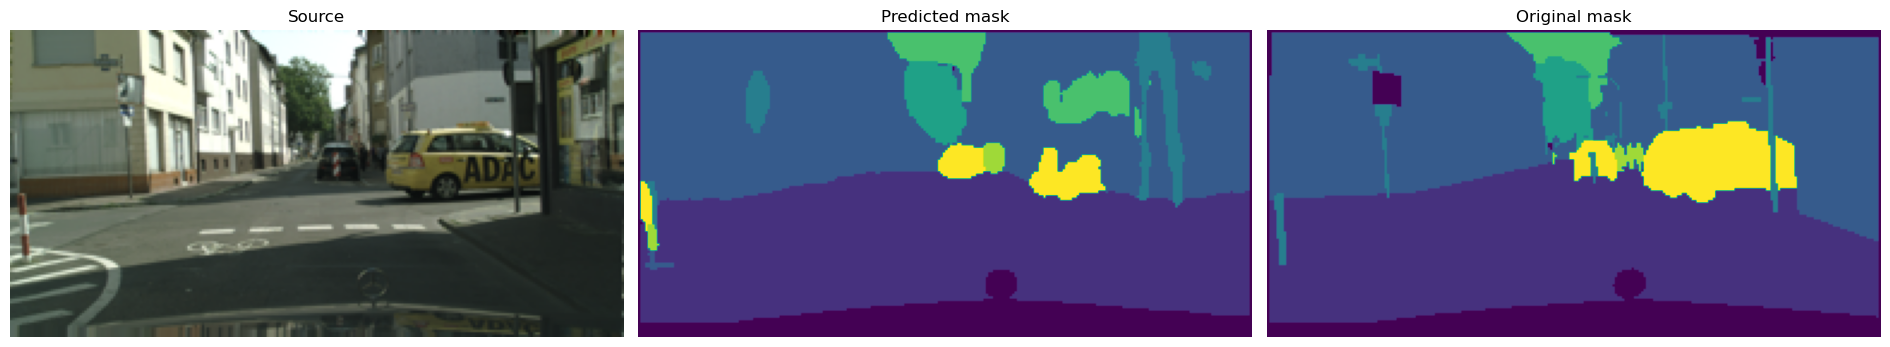

In [34]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [35]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [40]:
scorer.show_scores()

IoU      Dice  \
U-Net_baseline                                    0.552171  0.667224   
U-Net_baseline_with_data_augmentation_1           0.564558  0.680571   
U-Net_baseline_with_data_augmentation_2           0.559365  0.674603   
U-Net_baseline_with_data_augmentation_3           0.117844  0.197346   
U-Net_baseline_with_data_augmentation_2_diceLoss  0.631681  0.743959   

                                                  training_time  \
U-Net_baseline                                       517.575655   
U-Net_baseline_with_data_augmentation_1             1029.694759   
U-Net_baseline_with_data_augmentation_2              714.297488   
U-Net_baseline_with_data_augmentation_3              284.685457   
U-Net_baseline_with_data_augmentation_2_diceLoss     843.582155   

                                                  inference_time_500  \
U-Net_baseline                                              1.851263   
U-Net_baseline_with_data_augmentation_1                     2.369722   
U-Net_baseline_with_data_augmentation_2                     2.345822   
U-Net_baseline_with_data_augmentation_3                     2.193978   
U-Net_baseline_with_data_augmentation_2_diceLoss            2.138717   

                                                  inference_time_1  
U-Net_baseline                                            0.895139  
U-Net_baseline_with_data_augmentation_1                   0.423762  
U-Net_baseline_with_data_augmentation_2                   0.924520  
U-Net_baseline_with_data_augmentation_3                   0.414083  
U-Net_baseline_with_data_augmentation_2_diceLoss          0.903396

## 4.2 Utilisation d'un Weighted Dice comme fonction de perte <a class="anchor" id="loss_dice2"></a> [⇪](#menu)

### Préparons les training et validation sets **avec** data-augmentation

In [21]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transform2,
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Gardons le même modèle pour le moment

In [45]:
# 0 = void
# 1 = flat
# 2 = construction
# 3 = object
# 4 = nature
# 5 = sky
# 6 = human
# 7 = vehicules

class_w = np.array([0.5,1,1,1,0.5,0.5,2,2])

f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = sm.losses.DiceLoss(class_weights=class_w)
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = get_model_ref((128,256), 8)
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [46]:
model_name = "U-Net_baseline_with_data_augmentation_2_diceLossWeighted"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.5049 - iou_score: 0.4376 - f1-score: 0.5480
Epoch 1: val_iou_score improved from -inf to 0.17254, saving model to models/U-Net_baseline_with_data_augmentation_2_diceLossWeighted.keras
372/372 [==============================] - 31s 76ms/step - loss: 0.5049 - iou_score: 0.4376 - f1-score: 0.5480 - val_loss: 0.8074 - val_iou_score: 0.1725 - val_f1-score: 0.2339 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.3915 - iou_score: 0.5019 - f1-score: 0.6253
Epoch 2: val_iou_score improved from 0.17254 to 0.48735, saving model to models/U-Net_baseline_with_data_augmentation_2_diceLossWeighted.keras
372/372 [==============================] - 28s 75ms/step - loss: 0.3915 - iou_score: 0.5019 - f1-score: 0.6253 - val_loss: 0.3903 - val_iou_score: 0.4873 - val_f1-score: 0.6184 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.3525 - iou_score: 0.53

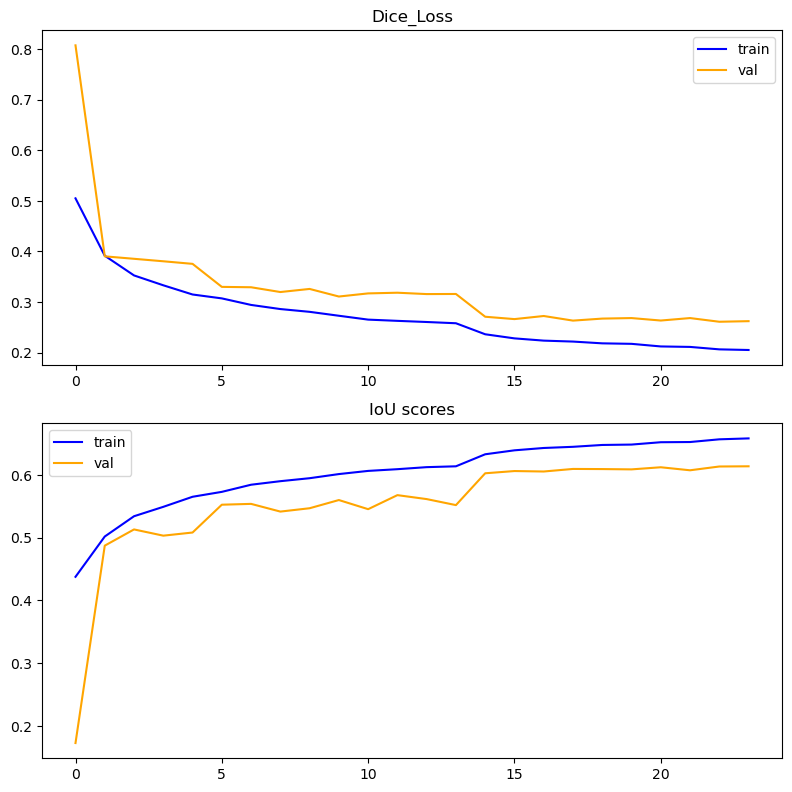

In [47]:
summarize_diagnostics(history)

In [48]:
model = keras.models.load_model(
    f"models/{model_name}.keras", 
    custom_objects={
        'iou_score':sm.metrics.iou_score, 
        'f1-score':sm.metrics.f1_score, 
        'dice_loss':sm.losses.DiceLoss() })

In [49]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 2s 26ms/step - loss: 0.2720 - iou_score: 0.6122 - f1-score: 0.7281
inference time (500 samples): 2.19s


### Test de prédiction

In [50]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [51]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 0s 390ms/step
Inference time: 0.42s


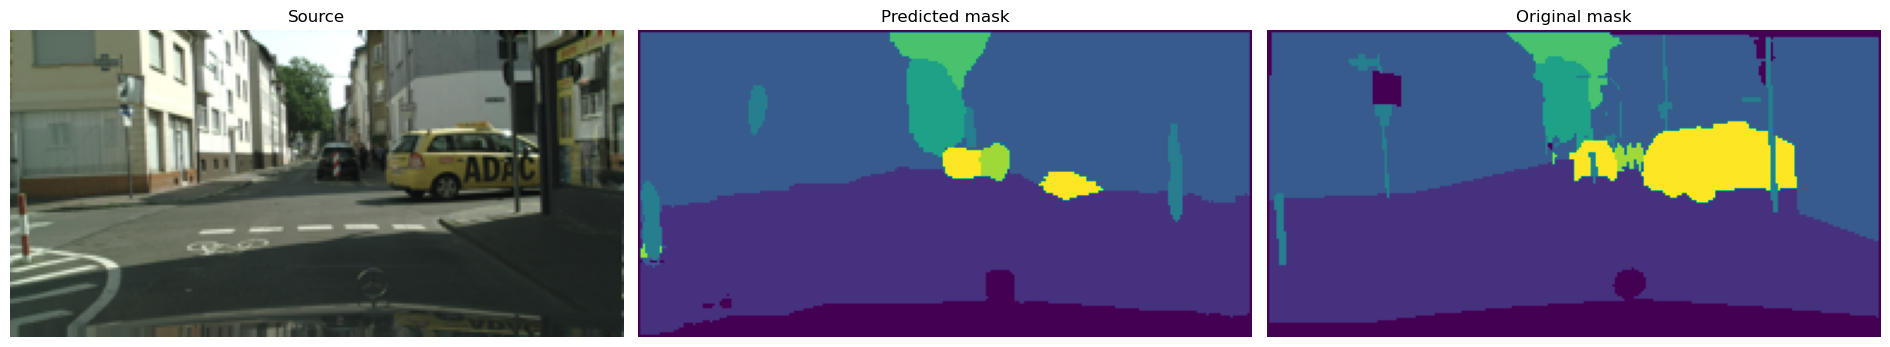

In [52]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [53]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [54]:
scorer.show_scores()

IoU      Dice  \
U-Net_baseline                                      0.552171  0.667224   
U-Net_baseline_with_data_augmentation_1             0.564558  0.680571   
U-Net_baseline_with_data_augmentation_2             0.559365  0.674603   
U-Net_baseline_with_data_augmentation_3             0.117844  0.197346   
U-Net_baseline_with_data_augmentation_2_diceLoss    0.631681  0.743959   
U-Net_baseline_with_data_augmentation_2_diceLos...  0.612228  0.728071   

                                                    training_time  \
U-Net_baseline                                         517.575655   
U-Net_baseline_with_data_augmentation_1               1029.694759   
U-Net_baseline_with_data_augmentation_2                714.297488   
U-Net_baseline_with_data_augmentation_3                284.685457   
U-Net_baseline_with_data_augmentation_2_diceLoss       843.582155   
U-Net_baseline_with_data_augmentation_2_diceLos...     697.217847   

                                                    inference_time_500  \
U-Net_baseline                                                1.851263   
U-Net_baseline_with_data_augmentation_1                       2.369722   
U-Net_baseline_with_data_augmentation_2                       2.345822   
U-Net_baseline_with_data_augmentation_3                       2.193978   
U-Net_baseline_with_data_augmentation_2_diceLoss              2.138717   
U-Net_baseline_with_data_augmentation_2_diceLos...            2.189904   

                                                    inference_time_1  
U-Net_baseline                                              0.895139  
U-Net_baseline_with_data_augmentation_1                     0.423762  
U-Net_baseline_with_data_augmentation_2                     0.924520  
U-Net_baseline_with_data_augmentation_3                     0.414083  
U-Net_baseline_with_data_augmentation_2_diceLoss            0.903396  
U-Net_baseline_with_data_augmentation_2_diceLos...          0.415433

## 4.3 Utilisation d'un FocalLoss avec `gamma=0.5` comme fonction de perte <a class="anchor" id="loss_focal"></a> [⇪](#menu)

### Préparons les training et validation sets **avec** data-augmentation

In [55]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transform2,
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Gardons le même modèle pour le moment

In [57]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = sm.losses.CategoricalFocalLoss(alpha=0.25, gamma=0.5)
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = get_model_ref((128,256), 8)
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [58]:
model_name = "U-Net_baseline_with_data_augmentation_2_focalLoss_0.25_0.5"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.0228 - iou_score: 0.3431 - f1-score: 0.4661
Epoch 1: val_iou_score improved from -inf to 0.10525, saving model to models/U-Net_baseline_with_data_augmentation_2_focalLoss_0.25_0.5.keras
372/372 [==============================] - 32s 79ms/step - loss: 0.0228 - iou_score: 0.3431 - f1-score: 0.4661 - val_loss: 0.0493 - val_iou_score: 0.1053 - val_f1-score: 0.1732 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.0150 - iou_score: 0.3990 - f1-score: 0.5264
Epoch 2: val_iou_score improved from 0.10525 to 0.38884, saving model to models/U-Net_baseline_with_data_augmentation_2_focalLoss_0.25_0.5.keras
372/372 [==============================] - 29s 78ms/step - loss: 0.0150 - iou_score: 0.3990 - f1-score: 0.5264 - val_loss: 0.0161 - val_iou_score: 0.3888 - val_f1-score: 0.5164 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.0136 - iou_score: 

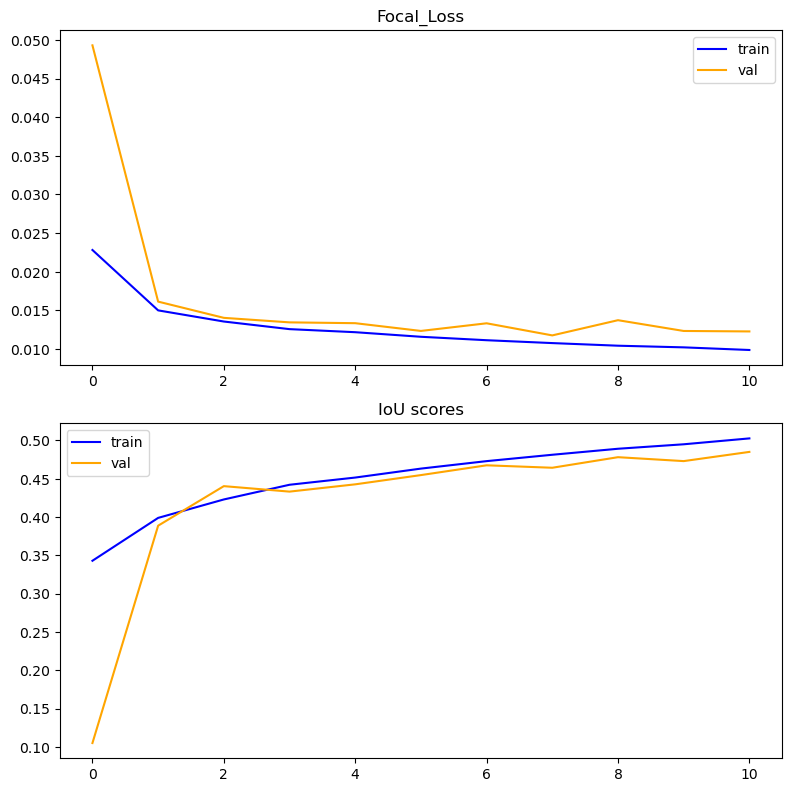

In [59]:
summarize_diagnostics(history)

In [60]:
model = keras.models.load_model(
    f"models/{model_name}.keras", 
    custom_objects={
        'iou_score':sm.metrics.iou_score, 
        'f1-score':sm.metrics.f1_score, 
        'focal_loss':sm.losses.CategoricalFocalLoss(alpha=0.25, gamma=0.5) })

In [61]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 3s 27ms/step - loss: 0.0123 - iou_score: 0.4867 - f1-score: 0.6124
inference time (500 samples): 2.65s


### Test de prédiction

In [62]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [63]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 0s 399ms/step
Inference time: 0.43s


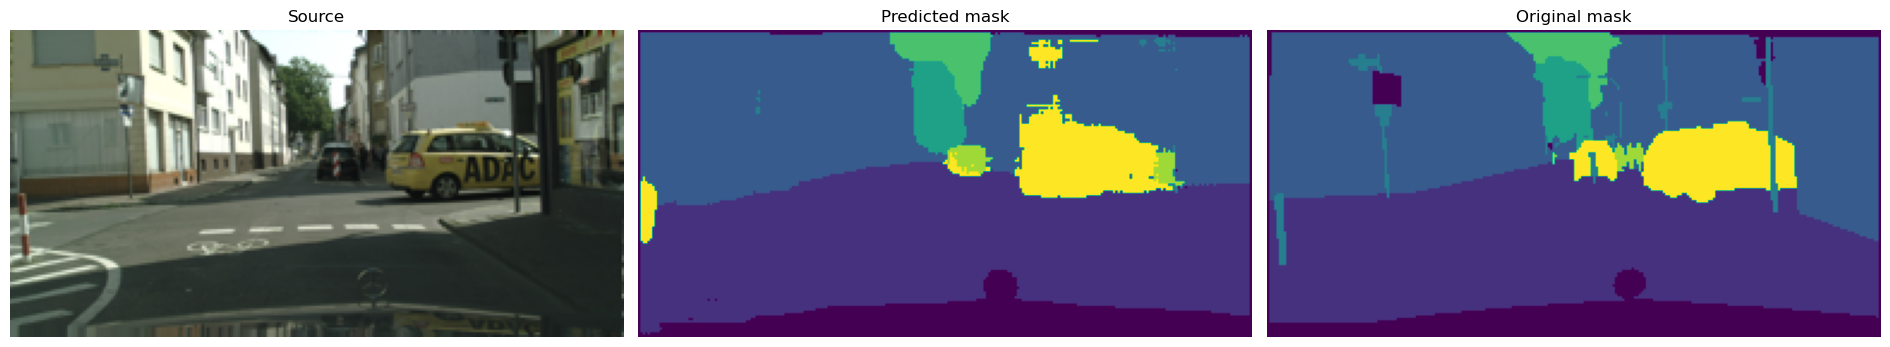

In [64]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [65]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [66]:
scorer.show_scores()

IoU      Dice  \
U-Net_baseline                                      0.552171  0.667224   
U-Net_baseline_with_data_augmentation_1             0.564558  0.680571   
U-Net_baseline_with_data_augmentation_2             0.559365  0.674603   
U-Net_baseline_with_data_augmentation_3             0.117844  0.197346   
U-Net_baseline_with_data_augmentation_2_diceLoss    0.631681  0.743959   
U-Net_baseline_with_data_augmentation_2_diceLos...  0.612228  0.728071   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.486711  0.612405   

                                                    training_time  \
U-Net_baseline                                         517.575655   
U-Net_baseline_with_data_augmentation_1               1029.694759   
U-Net_baseline_with_data_augmentation_2                714.297488   
U-Net_baseline_with_data_augmentation_3                284.685457   
U-Net_baseline_with_data_augmentation_2_diceLoss       843.582155   
U-Net_baseline_with_data_augmentation_2_diceLos...     697.217847   
U-Net_baseline_with_data_augmentation_2_focalLo...     326.424069   

                                                    inference_time_500  \
U-Net_baseline                                                1.851263   
U-Net_baseline_with_data_augmentation_1                       2.369722   
U-Net_baseline_with_data_augmentation_2                       2.345822   
U-Net_baseline_with_data_augmentation_3                       2.193978   
U-Net_baseline_with_data_augmentation_2_diceLoss              2.138717   
U-Net_baseline_with_data_augmentation_2_diceLos...            2.189904   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.646039   

                                                    inference_time_1  
U-Net_baseline                                              0.895139  
U-Net_baseline_with_data_augmentation_1                     0.423762  
U-Net_baseline_with_data_augmentation_2                     0.924520  
U-Net_baseline_with_data_augmentation_3                     0.414083  
U-Net_baseline_with_data_augmentation_2_diceLoss            0.903396  
U-Net_baseline_with_data_augmentation_2_diceLos...          0.415433  
U-Net_baseline_with_data_augmentation_2_focalLo...          0.425659

## 4.4 Utilisation d'un FocalLoss avec `gamma=1.0` comme fonction de perte <a class="anchor" id="loss_focal2"></a> [⇪](#menu)

### Préparons les training et validation sets **avec** data-augmentation

In [67]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transform2,
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Gardons le même modèle pour le moment

In [68]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = sm.losses.CategoricalFocalLoss(alpha=0.25, gamma=1.0)
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = get_model_ref((128,256), 8)
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [69]:
model_name = "U-Net_baseline_with_data_augmentation_2_focalLoss_0.25_1.0"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.0207 - iou_score: 0.3255 - f1-score: 0.4483
Epoch 1: val_iou_score improved from -inf to 0.08773, saving model to models/U-Net_baseline_with_data_augmentation_2_focalLoss_0.25_1.0.keras
372/372 [==============================] - 31s 78ms/step - loss: 0.0207 - iou_score: 0.3255 - f1-score: 0.4483 - val_loss: 0.0507 - val_iou_score: 0.0877 - val_f1-score: 0.1504 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.0131 - iou_score: 0.3713 - f1-score: 0.4999
Epoch 2: val_iou_score improved from 0.08773 to 0.37713, saving model to models/U-Net_baseline_with_data_augmentation_2_focalLoss_0.25_1.0.keras
372/372 [==============================] - 29s 78ms/step - loss: 0.0131 - iou_score: 0.3713 - f1-score: 0.4999 - val_loss: 0.0137 - val_iou_score: 0.3771 - val_f1-score: 0.5042 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.0117 - iou_score: 

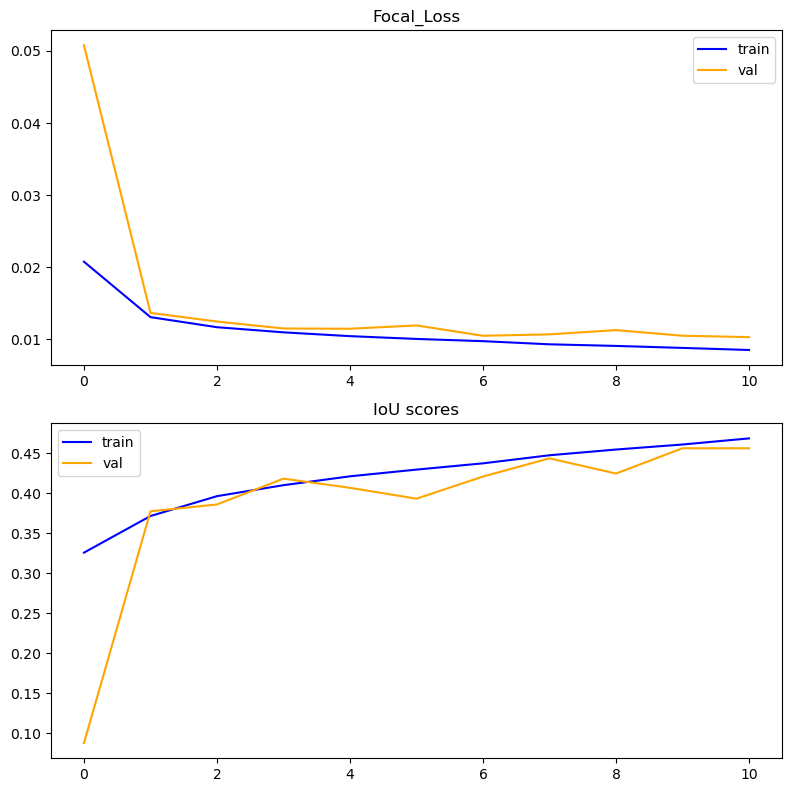

In [70]:
summarize_diagnostics(history)

In [71]:
model = keras.models.load_model(
    f"models/{model_name}.keras", 
    custom_objects={
        'iou_score':sm.metrics.iou_score, 
        'f1-score':sm.metrics.f1_score, 
        'focal_loss':sm.losses.CategoricalFocalLoss(alpha=0.25, gamma=1.0) })

In [72]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 2s 26ms/step - loss: 0.0105 - iou_score: 0.4541 - f1-score: 0.5857
inference time (500 samples): 2.21s


### Test de prédiction

In [73]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [74]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 0s 393ms/step
Inference time: 0.42s


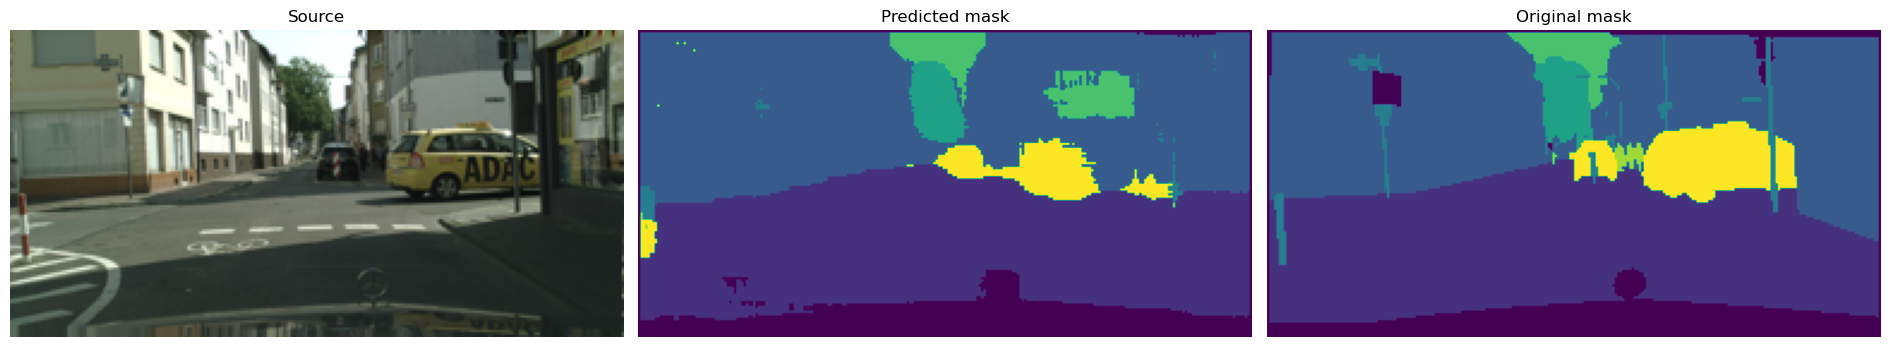

In [75]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [76]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [77]:
scorer.show_scores()

IoU      Dice  \
U-Net_baseline                                      0.552171  0.667224   
U-Net_baseline_with_data_augmentation_1             0.564558  0.680571   
U-Net_baseline_with_data_augmentation_2             0.559365  0.674603   
U-Net_baseline_with_data_augmentation_3             0.117844  0.197346   
U-Net_baseline_with_data_augmentation_2_diceLoss    0.631681  0.743959   
U-Net_baseline_with_data_augmentation_2_diceLos...  0.612228  0.728071   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.486711  0.612405   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.454141  0.585703   

                                                    training_time  \
U-Net_baseline                                         517.575655   
U-Net_baseline_with_data_augmentation_1               1029.694759   
U-Net_baseline_with_data_augmentation_2                714.297488   
U-Net_baseline_with_data_augmentation_3                284.685457   
U-Net_baseline_with_data_augmentation_2_diceLoss       843.582155   
U-Net_baseline_with_data_augmentation_2_diceLos...     697.217847   
U-Net_baseline_with_data_augmentation_2_focalLo...     326.424069   
U-Net_baseline_with_data_augmentation_2_focalLo...     318.810731   

                                                    inference_time_500  \
U-Net_baseline                                                1.851263   
U-Net_baseline_with_data_augmentation_1                       2.369722   
U-Net_baseline_with_data_augmentation_2                       2.345822   
U-Net_baseline_with_data_augmentation_3                       2.193978   
U-Net_baseline_with_data_augmentation_2_diceLoss              2.138717   
U-Net_baseline_with_data_augmentation_2_diceLos...            2.189904   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.646039   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.206589   

                                                    inference_time_1  
U-Net_baseline                                              0.895139  
U-Net_baseline_with_data_augmentation_1                     0.423762  
U-Net_baseline_with_data_augmentation_2                     0.924520  
U-Net_baseline_with_data_augmentation_3                     0.414083  
U-Net_baseline_with_data_augmentation_2_diceLoss            0.903396  
U-Net_baseline_with_data_augmentation_2_diceLos...          0.415433  
U-Net_baseline_with_data_augmentation_2_focalLo...          0.425659  
U-Net_baseline_with_data_augmentation_2_focalLo...          0.418523

## 4.5 Utilisation d'un mix Categorical_Cross_Entropy + Dice (50/50) comme fonction de perte <a class="anchor" id="loss_mix"></a> [⇪](#menu)

### Préparons les training et validation sets **avec** data-augmentation

In [83]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transform2,
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Gardons le même modèle pour le moment

In [84]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = sm.losses.CategoricalCELoss() + sm.losses.DiceLoss()
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = get_model_ref((128,256), 8)
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [85]:
model_name = "U-Net_baseline_with_data_augmentation_2_cceDiceLoss_50_50"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.5641 - iou_score: 0.4429 - f1-score: 0.5651
Epoch 1: val_iou_score improved from -inf to 0.09696, saving model to models/U-Net_baseline_with_data_augmentation_2_cceDiceLoss_50_50.keras
372/372 [==============================] - 32s 79ms/step - loss: 0.5641 - iou_score: 0.4429 - f1-score: 0.5651 - val_loss: 1.1875 - val_iou_score: 0.0970 - val_f1-score: 0.1589 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.4530 - iou_score: 0.5140 - f1-score: 0.6365
Epoch 2: val_iou_score improved from 0.09696 to 0.46970, saving model to models/U-Net_baseline_with_data_augmentation_2_cceDiceLoss_50_50.keras
372/372 [==============================] - 30s 80ms/step - loss: 0.4530 - iou_score: 0.5140 - f1-score: 0.6365 - val_loss: 0.5059 - val_iou_score: 0.4697 - val_f1-score: 0.5977 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.4238 - iou_score: 0.

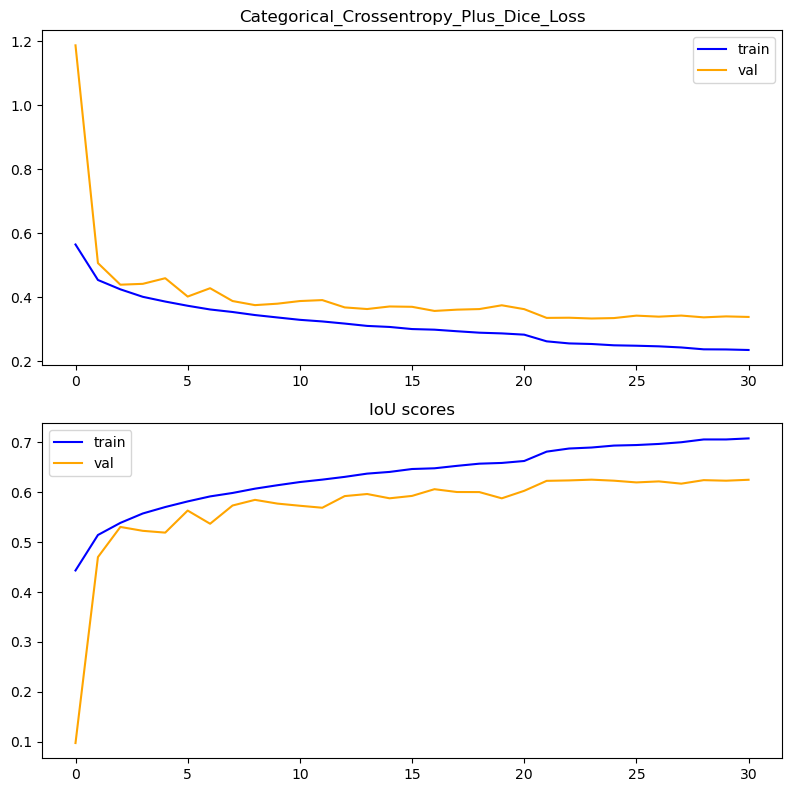

In [86]:
summarize_diagnostics(history)

In [90]:
model = keras.models.load_model(
    f"models/{model_name}.keras", 
    custom_objects={
        'iou_score':sm.metrics.iou_score, 
        'f1-score':sm.metrics.f1_score, 
        'categorical_crossentropy_plus_dice_loss':sm.losses.CategoricalCELoss() + sm.losses.DiceLoss(),
    })

In [91]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 2s 26ms/step - loss: 0.3348 - iou_score: 0.6228 - f1-score: 0.7385
inference time (500 samples): 2.22s


### Test de prédiction

In [92]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [93]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 0s 389ms/step
Inference time: 0.42s


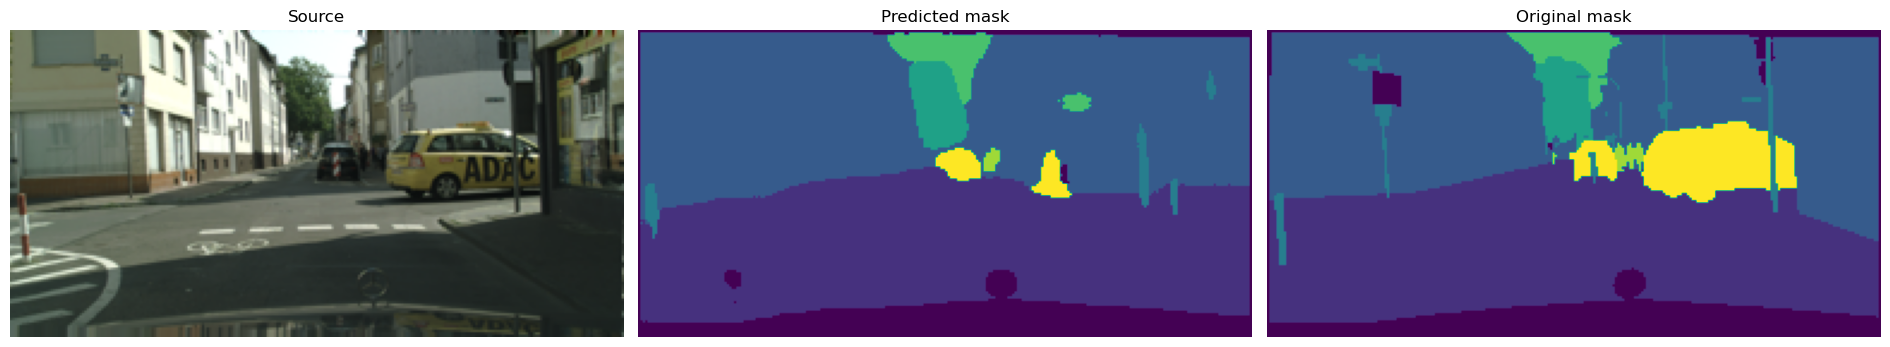

In [94]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [95]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [96]:
scorer.show_scores()

IoU      Dice  \
U-Net_baseline                                      0.552171  0.667224   
U-Net_baseline_with_data_augmentation_1             0.564558  0.680571   
U-Net_baseline_with_data_augmentation_2             0.559365  0.674603   
U-Net_baseline_with_data_augmentation_3             0.117844  0.197346   
U-Net_baseline_with_data_augmentation_2_diceLoss    0.631681  0.743959   
U-Net_baseline_with_data_augmentation_2_diceLos...  0.612228  0.728071   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.486711  0.612405   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.454141  0.585703   
U-Net_baseline_with_data_augmentation_2_cceDice...  0.622789  0.738499   

                                                    training_time  \
U-Net_baseline                                         517.575655   
U-Net_baseline_with_data_augmentation_1               1029.694759   
U-Net_baseline_with_data_augmentation_2                714.297488   
U-Net_baseline_with_data_augmentation_3                284.685457   
U-Net_baseline_with_data_augmentation_2_diceLoss       843.582155   
U-Net_baseline_with_data_augmentation_2_diceLos...     697.217847   
U-Net_baseline_with_data_augmentation_2_focalLo...     326.424069   
U-Net_baseline_with_data_augmentation_2_focalLo...     318.810731   
U-Net_baseline_with_data_augmentation_2_cceDice...     899.124581   

                                                    inference_time_500  \
U-Net_baseline                                                1.851263   
U-Net_baseline_with_data_augmentation_1                       2.369722   
U-Net_baseline_with_data_augmentation_2                       2.345822   
U-Net_baseline_with_data_augmentation_3                       2.193978   
U-Net_baseline_with_data_augmentation_2_diceLoss              2.138717   
U-Net_baseline_with_data_augmentation_2_diceLos...            2.189904   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.646039   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.206589   
U-Net_baseline_with_data_augmentation_2_cceDice...            2.216438   

                                                    inference_time_1  
U-Net_baseline                                              0.895139  
U-Net_baseline_with_data_augmentation_1                     0.423762  
U-Net_baseline_with_data_augmentation_2                     0.924520  
U-Net_baseline_with_data_augmentation_3                     0.414083  
U-Net_baseline_with_data_augmentation_2_diceLoss            0.903396  
U-Net_baseline_with_data_augmentation_2_diceLos...          0.415433  
U-Net_baseline_with_data_augmentation_2_focalLo...          0.425659  
U-Net_baseline_with_data_augmentation_2_focalLo...          0.418523  
U-Net_baseline_with_data_augmentation_2_cceDice...          0.415926

## 4.6 Utilisation d'un mix Categorical_Cross_Entropy + Dice (0.5/1.0) comme fonction de perte <a class="anchor" id="loss_mix2"></a> [⇪](#menu)

### Préparons les training et validation sets **avec** data-augmentation

In [97]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transform2,
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    # preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Gardons le même modèle pour le moment

In [98]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = sm.losses.CategoricalCELoss()*0.5 + sm.losses.DiceLoss()*1.0
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = get_model_ref((128,256), 8)
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [99]:
model_name = "U-Net_baseline_with_data_augmentation_2_cceDiceLoss_0.5_1.0"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.4911 - iou_score: 0.4587 - f1-score: 0.5808
Epoch 1: val_iou_score improved from -inf to 0.08977, saving model to models/U-Net_baseline_with_data_augmentation_2_cceDiceLoss_0.5_1.0.keras
372/372 [==============================] - 32s 80ms/step - loss: 0.4911 - iou_score: 0.4587 - f1-score: 0.5808 - val_loss: 1.1438 - val_iou_score: 0.0898 - val_f1-score: 0.1355 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.4028 - iou_score: 0.5265 - f1-score: 0.6486
Epoch 2: val_iou_score improved from 0.08977 to 0.51935, saving model to models/U-Net_baseline_with_data_augmentation_2_cceDiceLoss_0.5_1.0.keras
372/372 [==============================] - 29s 79ms/step - loss: 0.4028 - iou_score: 0.5265 - f1-score: 0.6486 - val_loss: 0.4130 - val_iou_score: 0.5194 - val_f1-score: 0.6383 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.3722 - iou_score

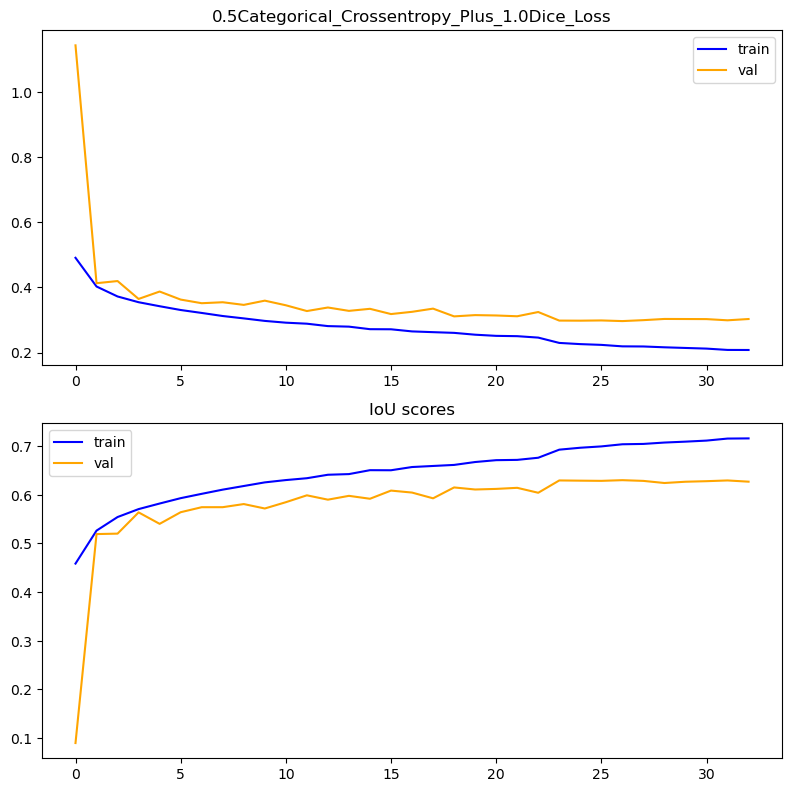

In [100]:
summarize_diagnostics(history)

In [103]:
model = keras.models.load_model(
    f"models/{model_name}.keras", 
    custom_objects={
        'iou_score':sm.metrics.iou_score, 
        'f1-score':sm.metrics.f1_score, 
        '0.5categorical_crossentropy_plus_1.0dice_loss':f_loss,
    })

In [104]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 2s 26ms/step - loss: 0.2973 - iou_score: 0.6284 - f1-score: 0.7429
inference time (500 samples): 2.26s


### Test de prédiction

In [105]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [106]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 0s 417ms/step
Inference time: 0.44s


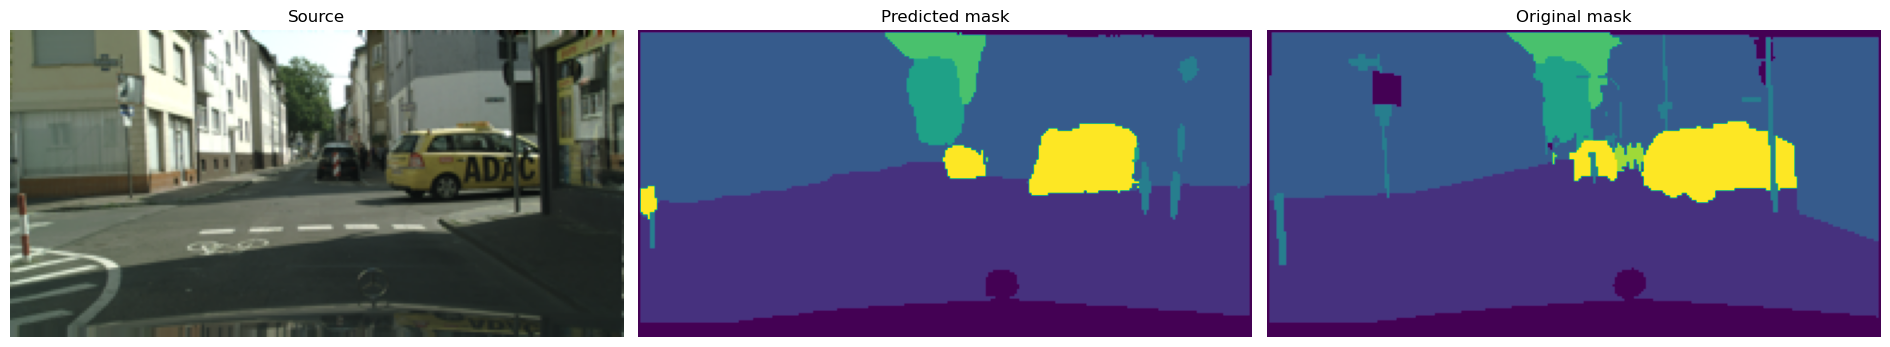

In [107]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [108]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [109]:
scorer.show_scores()

IoU      Dice  \
U-Net_baseline                                      0.552171  0.667224   
U-Net_baseline_with_data_augmentation_1             0.564558  0.680571   
U-Net_baseline_with_data_augmentation_2             0.559365  0.674603   
U-Net_baseline_with_data_augmentation_3             0.117844  0.197346   
U-Net_baseline_with_data_augmentation_2_diceLoss    0.631681  0.743959   
U-Net_baseline_with_data_augmentation_2_diceLos...  0.612228  0.728071   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.486711  0.612405   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.454141  0.585703   
U-Net_baseline_with_data_augmentation_2_cceDice...  0.622789  0.738499   
U-Net_baseline_with_data_augmentation_2_cceDice...  0.628407  0.742861   

                                                    training_time  \
U-Net_baseline                                         517.575655   
U-Net_baseline_with_data_augmentation_1               1029.694759   
U-Net_baseline_with_data_augmentation_2                714.297488   
U-Net_baseline_with_data_augmentation_3                284.685457   
U-Net_baseline_with_data_augmentation_2_diceLoss       843.582155   
U-Net_baseline_with_data_augmentation_2_diceLos...     697.217847   
U-Net_baseline_with_data_augmentation_2_focalLo...     326.424069   
U-Net_baseline_with_data_augmentation_2_focalLo...     318.810731   
U-Net_baseline_with_data_augmentation_2_cceDice...     899.124581   
U-Net_baseline_with_data_augmentation_2_cceDice...     995.207425   

                                                    inference_time_500  \
U-Net_baseline                                                1.851263   
U-Net_baseline_with_data_augmentation_1                       2.369722   
U-Net_baseline_with_data_augmentation_2                       2.345822   
U-Net_baseline_with_data_augmentation_3                       2.193978   
U-Net_baseline_with_data_augmentation_2_diceLoss              2.138717   
U-Net_baseline_with_data_augmentation_2_diceLos...            2.189904   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.646039   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.206589   
U-Net_baseline_with_data_augmentation_2_cceDice...            2.216438   
U-Net_baseline_with_data_augmentation_2_cceDice...            2.260605   

                                                    inference_time_1  
U-Net_baseline                                              0.895139  
U-Net_baseline_with_data_augmentation_1                     0.423762  
U-Net_baseline_with_data_augmentation_2                     0.924520  
U-Net_baseline_with_data_augmentation_3                     0.414083  
U-Net_baseline_with_data_augmentation_2_diceLoss            0.903396  
U-Net_baseline_with_data_augmentation_2_diceLos...          0.415433  
U-Net_baseline_with_data_augmentation_2_focalLo...          0.425659  
U-Net_baseline_with_data_augmentation_2_focalLo...          0.418523  
U-Net_baseline_with_data_augmentation_2_cceDice...          0.415926  
U-Net_baseline_with_data_augmentation_2_cceDice...          0.444320

> ### Conclusion <a class="anchor" id="loss_results"></a>
> A ce stade, le meilleur modèle semble être `U-Net_baseline_with_data_augmentation_2_diceLoss` qui utilise donc une fonction de coût Dice seule.
>
> Nous allons donc à présent essayer différentes architectures en utilisant notre second jeu de transformation `transform2` une fonction de perte `Dice`.

---
---
# 5. Recherche d'une meilleure architecture <a class="anchor" id="archi"></a> [⇪](#menu)

## 5.1 U-Net sur un backbone Resnet152 <a class="anchor" id="archi1"></a> [⇪](#menu)

### Définissons un pré-processing

In [110]:
BACKBONE = 'resnet152'
preprocess_input = sm.get_preprocessing(BACKBONE)

### Préparons les training et validation sets **avec** data-augmentation

In [113]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transform2,
    preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Définissons et entrainons un modèle

In [114]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = sm.losses.DiceLoss() 
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=8, activation='softmax')
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [115]:
model_name = "U-Net-resetnet152_with_data_augmentation_2_diceLoss"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.3837 - iou_score: 0.5023 - f1-score: 0.6163
Epoch 1: val_iou_score improved from -inf to 0.12742, saving model to models/U-Net-resetnet152_with_data_augmentation_2_diceLoss.keras
372/372 [==============================] - 118s 272ms/step - loss: 0.3837 - iou_score: 0.5023 - f1-score: 0.6163 - val_loss: 0.7998 - val_iou_score: 0.1274 - val_f1-score: 0.2001 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.2583 - iou_score: 0.6276 - f1-score: 0.7417
Epoch 2: val_iou_score improved from 0.12742 to 0.17034, saving model to models/U-Net-resetnet152_with_data_augmentation_2_diceLoss.keras
372/372 [==============================] - 102s 274ms/step - loss: 0.2583 - iou_score: 0.6276 - f1-score: 0.7417 - val_loss: 0.7599 - val_iou_score: 0.1703 - val_f1-score: 0.2406 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.2324 - iou_score: 0.6574 - f

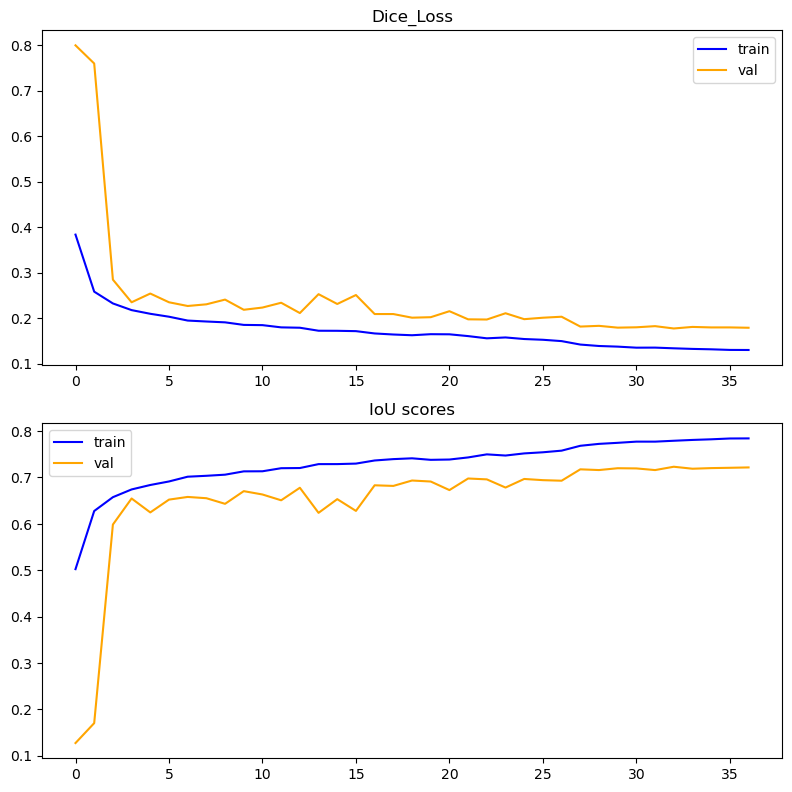

In [116]:
summarize_diagnostics(history)

In [117]:
model = keras.models.load_model(
    f"models/{model_name}.keras", 
    custom_objects={
        'iou_score':sm.metrics.iou_score, 
        'f1-score':sm.metrics.f1_score, 
        'dice_loss':sm.losses.DiceLoss() })

In [118]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 6s 64ms/step - loss: 0.1779 - iou_score: 0.7221 - f1-score: 0.8221
inference time (500 samples): 6.31s


### Test de prédiction

In [119]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [120]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 3s 3s/step
Inference time: 3.41s


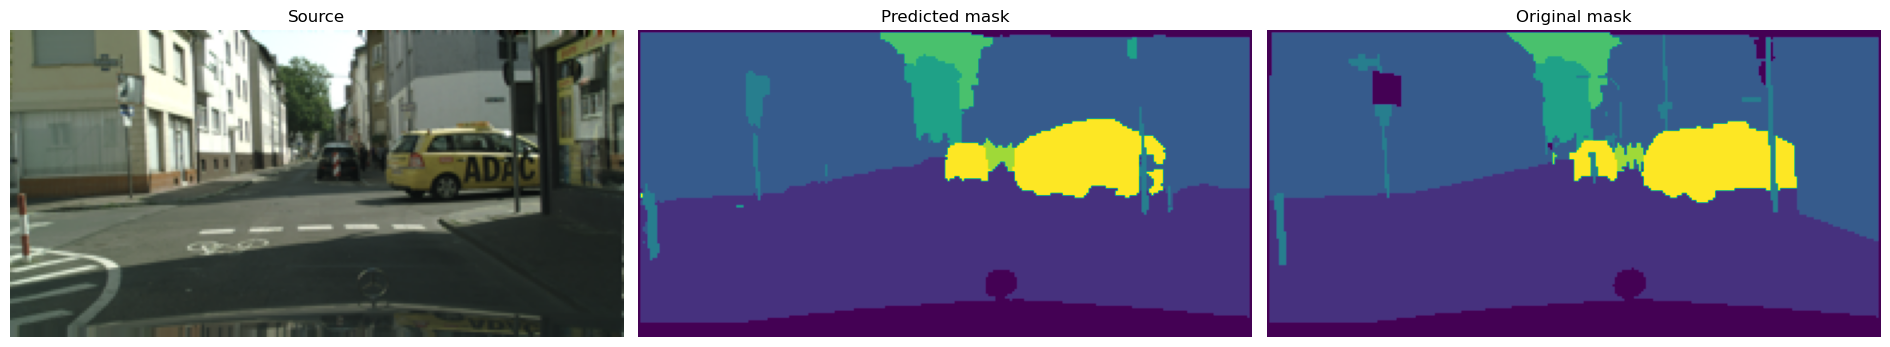

In [121]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [122]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [123]:
scorer.show_scores()

IoU      Dice  \
U-Net_baseline                                      0.552171  0.667224   
U-Net_baseline_with_data_augmentation_1             0.564558  0.680571   
U-Net_baseline_with_data_augmentation_2             0.559365  0.674603   
U-Net_baseline_with_data_augmentation_3             0.117844  0.197346   
U-Net_baseline_with_data_augmentation_2_diceLoss    0.631681  0.743959   
U-Net_baseline_with_data_augmentation_2_diceLos...  0.612228  0.728071   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.486711  0.612405   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.454141  0.585703   
U-Net_baseline_with_data_augmentation_2_cceDice...  0.622789  0.738499   
U-Net_baseline_with_data_augmentation_2_cceDice...  0.628407  0.742861   
U-Net-resetnet152_with_data_augmentation_2_dice...  0.722085  0.822108   

                                                    training_time  \
U-Net_baseline                                         517.575655   
U-Net_baseline_with_data_augmentation_1               1029.694759   
U-Net_baseline_with_data_augmentation_2                714.297488   
U-Net_baseline_with_data_augmentation_3                284.685457   
U-Net_baseline_with_data_augmentation_2_diceLoss       843.582155   
U-Net_baseline_with_data_augmentation_2_diceLos...     697.217847   
U-Net_baseline_with_data_augmentation_2_focalLo...     326.424069   
U-Net_baseline_with_data_augmentation_2_focalLo...     318.810731   
U-Net_baseline_with_data_augmentation_2_cceDice...     899.124581   
U-Net_baseline_with_data_augmentation_2_cceDice...     995.207425   
U-Net-resetnet152_with_data_augmentation_2_dice...    3538.612212   

                                                    inference_time_500  \
U-Net_baseline                                                1.851263   
U-Net_baseline_with_data_augmentation_1                       2.369722   
U-Net_baseline_with_data_augmentation_2                       2.345822   
U-Net_baseline_with_data_augmentation_3                       2.193978   
U-Net_baseline_with_data_augmentation_2_diceLoss              2.138717   
U-Net_baseline_with_data_augmentation_2_diceLos...            2.189904   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.646039   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.206589   
U-Net_baseline_with_data_augmentation_2_cceDice...            2.216438   
U-Net_baseline_with_data_augmentation_2_cceDice...            2.260605   
U-Net-resetnet152_with_data_augmentation_2_dice...            6.312516   

                                                    inference_time_1  
U-Net_baseline                                              0.895139  
U-Net_baseline_with_data_augmentation_1                     0.423762  
U-Net_baseline_with_data_augmentation_2                     0.924520  
U-Net_baseline_with_data_augmentation_3                     0.414083  
U-Net_baseline_with_data_augmentation_2_diceLoss            0.903396  
U-Net_baseline_with_data_augmentation_2_diceLos...          0.415433  
U-Net_baseline_with_data_augmentation_2_focalLo...          0.425659  
U-Net_baseline_with_data_augmentation_2_focalLo...          0.418523  
U-Net_baseline_with_data_augmentation_2_cceDice...          0.415926  
U-Net_baseline_with_data_augmentation_2_cceDice...          0.444320  
U-Net-resetnet152_with_data_augmentation_2_dice...          3.414692

## 5.2 U-Net sur un backbone VGG19 <a class="anchor" id="archi2"></a> [⇪](#menu)

### Définissons un pré-processing

In [14]:
BACKBONE = 'vgg19'
preprocess_input = sm.get_preprocessing(BACKBONE)

### Préparons les training et validation sets **avec** data-augmentation

In [15]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transform2,
    preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Définissons et entrainons un modèle

In [17]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = sm.losses.DiceLoss() 
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=8, activation='softmax')
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [19]:
model_name = "U-Net-vgg19_with_data_augmentation_2_diceLoss"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.3875 - iou_score: 0.4979 - f1-score: 0.6125
Epoch 1: val_iou_score improved from -inf to 0.51974, saving model to models/U-Net-vgg19_with_data_augmentation_2_diceLoss.keras
372/372 [==============================] - 62s 166ms/step - loss: 0.3875 - iou_score: 0.4979 - f1-score: 0.6125 - val_loss: 0.3428 - val_iou_score: 0.5197 - val_f1-score: 0.6564 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.2542 - iou_score: 0.6310 - f1-score: 0.7458
Epoch 2: val_iou_score improved from 0.51974 to 0.62761, saving model to models/U-Net-vgg19_with_data_augmentation_2_diceLoss.keras
372/372 [==============================] - 58s 156ms/step - loss: 0.2542 - iou_score: 0.6310 - f1-score: 0.7458 - val_loss: 0.2538 - val_iou_score: 0.6276 - val_f1-score: 0.7460 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.2273 - iou_score: 0.6619 - f1-score: 0.772

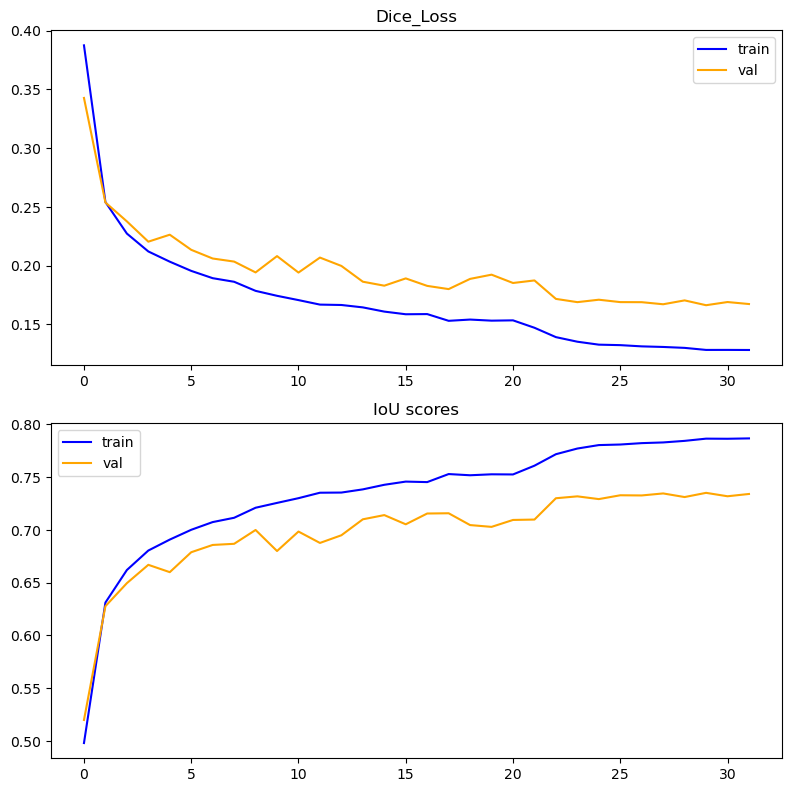

In [20]:
summarize_diagnostics(history)

In [21]:
model = keras.models.load_model(
    f"models/{model_name}.keras", 
    custom_objects={
        'iou_score':sm.metrics.iou_score, 
        'f1-score':sm.metrics.f1_score, 
        'dice_loss':sm.losses.DiceLoss() })

In [28]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 3s 45ms/step - loss: 0.1670 - iou_score: 0.7346 - f1-score: 0.8329
inference time (500 samples): 3.10s


### Test de prédiction

In [29]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [30]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 0s 19ms/step
Inference time: 0.05s


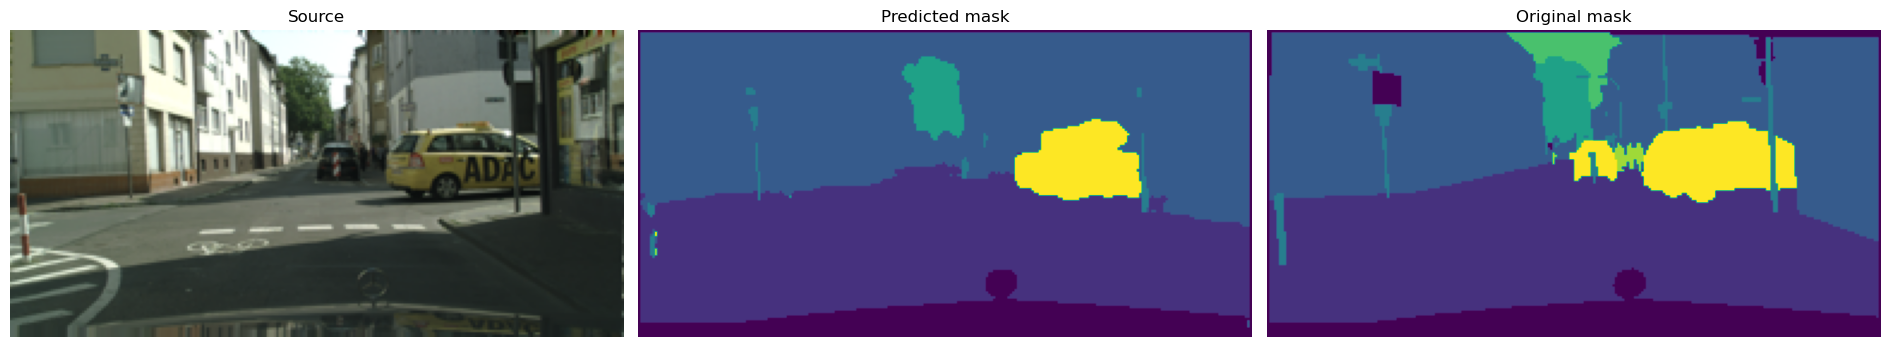

In [31]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [32]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [33]:
scorer.show_scores()

IoU      Dice  \
U-Net_baseline                                      0.552171  0.667224   
U-Net_baseline_with_data_augmentation_1             0.564558  0.680571   
U-Net_baseline_with_data_augmentation_2             0.559365  0.674603   
U-Net_baseline_with_data_augmentation_3             0.117844  0.197346   
U-Net_baseline_with_data_augmentation_2_diceLoss    0.631681  0.743959   
U-Net_baseline_with_data_augmentation_2_diceLos...  0.612228  0.728071   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.486711  0.612405   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.454141  0.585703   
U-Net_baseline_with_data_augmentation_2_cceDice...  0.622789  0.738499   
U-Net_baseline_with_data_augmentation_2_cceDice...  0.628407  0.742861   
U-Net-resetnet152_with_data_augmentation_2_dice...  0.722085  0.822108   
U-Net-vgg19_with_data_augmentation_2_diceLoss       0.734644  0.832938   

                                                    training_time  \
U-Net_baseline                                         517.575655   
U-Net_baseline_with_data_augmentation_1               1029.694759   
U-Net_baseline_with_data_augmentation_2                714.297488   
U-Net_baseline_with_data_augmentation_3                284.685457   
U-Net_baseline_with_data_augmentation_2_diceLoss       843.582155   
U-Net_baseline_with_data_augmentation_2_diceLos...     697.217847   
U-Net_baseline_with_data_augmentation_2_focalLo...     326.424069   
U-Net_baseline_with_data_augmentation_2_focalLo...     318.810731   
U-Net_baseline_with_data_augmentation_2_cceDice...     899.124581   
U-Net_baseline_with_data_augmentation_2_cceDice...     995.207425   
U-Net-resetnet152_with_data_augmentation_2_dice...    3538.612212   
U-Net-vgg19_with_data_augmentation_2_diceLoss         1932.282903   

                                                    inference_time_500  \
U-Net_baseline                                                1.851263   
U-Net_baseline_with_data_augmentation_1                       2.369722   
U-Net_baseline_with_data_augmentation_2                       2.345822   
U-Net_baseline_with_data_augmentation_3                       2.193978   
U-Net_baseline_with_data_augmentation_2_diceLoss              2.138717   
U-Net_baseline_with_data_augmentation_2_diceLos...            2.189904   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.646039   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.206589   
U-Net_baseline_with_data_augmentation_2_cceDice...            2.216438   
U-Net_baseline_with_data_augmentation_2_cceDice...            2.260605   
U-Net-resetnet152_with_data_augmentation_2_dice...            6.312516   
U-Net-vgg19_with_data_augmentation_2_diceLoss                 3.101655   

                                                    inference_time_1  
U-Net_baseline                                              0.895139  
U-Net_baseline_with_data_augmentation_1                     0.423762  
U-Net_baseline_with_data_augmentation_2                     0.924520  
U-Net_baseline_with_data_augmentation_3                     0.414083  
U-Net_baseline_with_data_augmentation_2_diceLoss            0.903396  
U-Net_baseline_with_data_augmentation_2_diceLos...          0.415433  
U-Net_baseline_with_data_augmentation_2_focalLo...          0.425659  
U-Net_baseline_with_data_augmentation_2_focalLo...          0.418523  
U-Net_baseline_with_data_augmentation_2_cceDice...          0.415926  
U-Net_baseline_with_data_augmentation_2_cceDice...          0.444320  
U-Net-resetnet152_with_data_augmentation_2_dice...          3.414692  
U-Net-vgg19_with_data_augmentation_2_diceLoss               0.048437

## 5.3 U-Net sur un backbone ResNext101 <a class="anchor" id="archi3"></a> [⇪](#menu)

### Définissons un pré-processing

In [37]:
BACKBONE = 'resnext101'
preprocess_input = sm.get_preprocessing(BACKBONE)

### Préparons les training et validation sets **avec** data-augmentation

In [38]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transform2,
    preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Définissons et entrainons un modèle

In [39]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = sm.losses.DiceLoss() 
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=8, activation='softmax')
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

173622728/173622728 [==============================] - 1s 0us/step


In [40]:
model_name = "U-Net-resnext101_with_data_augmentation_2_diceLoss"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.3512 - iou_score: 0.5323 - f1-score: 0.6488
Epoch 1: val_iou_score improved from -inf to 0.17115, saving model to models/U-Net-resnext101_with_data_augmentation_2_diceLoss.keras
372/372 [==============================] - 214s 394ms/step - loss: 0.3512 - iou_score: 0.5323 - f1-score: 0.6488 - val_loss: 0.7737 - val_iou_score: 0.1712 - val_f1-score: 0.2261 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.2394 - iou_score: 0.6486 - f1-score: 0.7606
Epoch 2: val_iou_score improved from 0.17115 to 0.21200, saving model to models/U-Net-resnext101_with_data_augmentation_2_diceLoss.keras
372/372 [==============================] - 140s 376ms/step - loss: 0.2394 - iou_score: 0.6486 - f1-score: 0.7606 - val_loss: 0.7050 - val_iou_score: 0.2120 - val_f1-score: 0.2946 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.2205 - iou_score: 0.6701 - f1-

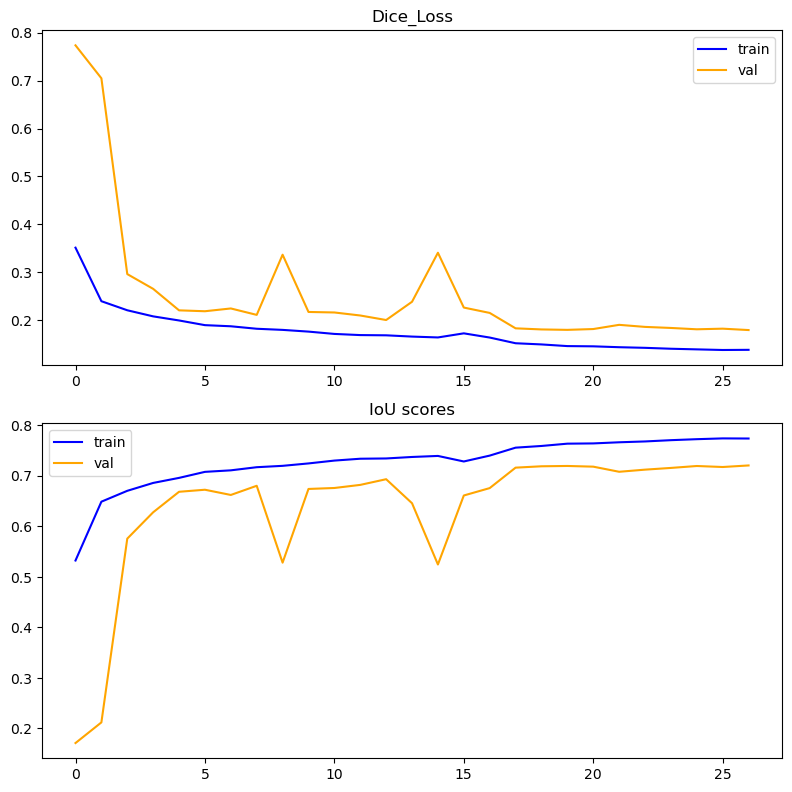

In [41]:
summarize_diagnostics(history)

In [42]:
model = keras.models.load_model(
    f"models/{model_name}.keras", 
    custom_objects={
        'iou_score':sm.metrics.iou_score, 
        'f1-score':sm.metrics.f1_score, 
        'dice_loss':sm.losses.DiceLoss() })

In [54]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 5s 83ms/step - loss: 0.1793 - iou_score: 0.7206 - f1-score: 0.8209
inference time (500 samples): 5.38s


### Test de prédiction

In [55]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [56]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 0s 89ms/step
Inference time: 0.13s


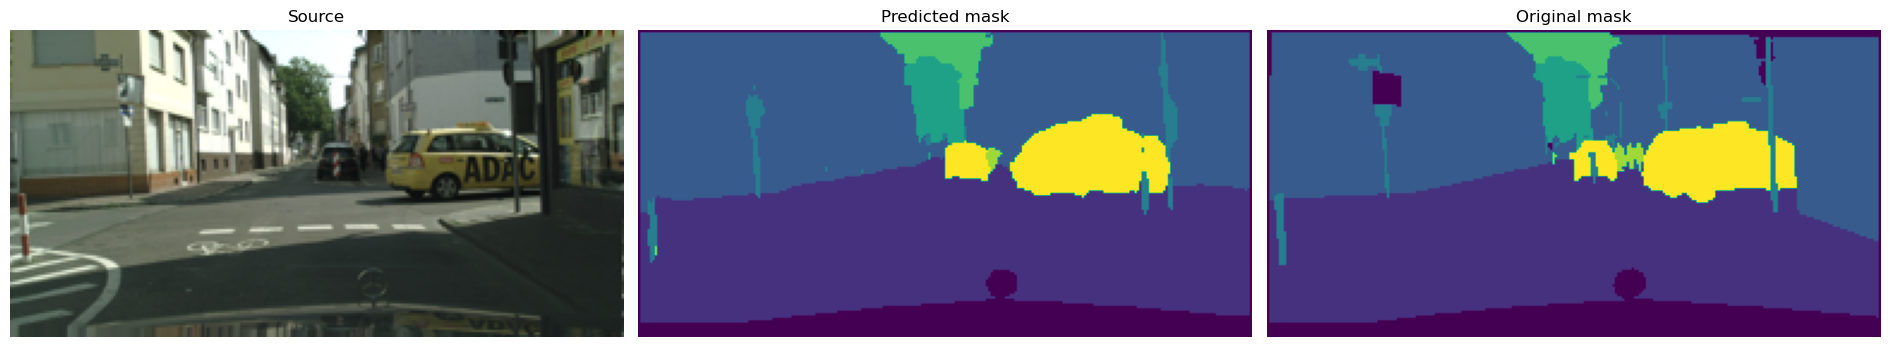

In [57]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [58]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [59]:
scorer.show_scores()

IoU      Dice  \
U-Net_baseline                                      0.552171  0.667224   
U-Net_baseline_with_data_augmentation_1             0.564558  0.680571   
U-Net_baseline_with_data_augmentation_2             0.559365  0.674603   
U-Net_baseline_with_data_augmentation_3             0.117844  0.197346   
U-Net_baseline_with_data_augmentation_2_diceLoss    0.631681  0.743959   
U-Net_baseline_with_data_augmentation_2_diceLos...  0.612228  0.728071   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.486711  0.612405   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.454141  0.585703   
U-Net_baseline_with_data_augmentation_2_cceDice...  0.622789  0.738499   
U-Net_baseline_with_data_augmentation_2_cceDice...  0.628407  0.742861   
U-Net-resetnet152_with_data_augmentation_2_dice...  0.722085  0.822108   
U-Net-vgg19_with_data_augmentation_2_diceLoss       0.734644  0.832938   
U-Net-resnext101_with_data_augmentation_2_diceLoss  0.720611  0.820914   

                                                    training_time  \
U-Net_baseline                                         517.575655   
U-Net_baseline_with_data_augmentation_1               1029.694759   
U-Net_baseline_with_data_augmentation_2                714.297488   
U-Net_baseline_with_data_augmentation_3                284.685457   
U-Net_baseline_with_data_augmentation_2_diceLoss       843.582155   
U-Net_baseline_with_data_augmentation_2_diceLos...     697.217847   
U-Net_baseline_with_data_augmentation_2_focalLo...     326.424069   
U-Net_baseline_with_data_augmentation_2_focalLo...     318.810731   
U-Net_baseline_with_data_augmentation_2_cceDice...     899.124581   
U-Net_baseline_with_data_augmentation_2_cceDice...     995.207425   
U-Net-resetnet152_with_data_augmentation_2_dice...    3538.612212   
U-Net-vgg19_with_data_augmentation_2_diceLoss         1932.282903   
U-Net-resnext101_with_data_augmentation_2_diceLoss    3738.743413   

                                                    inference_time_500  \
U-Net_baseline                                                1.851263   
U-Net_baseline_with_data_augmentation_1                       2.369722   
U-Net_baseline_with_data_augmentation_2                       2.345822   
U-Net_baseline_with_data_augmentation_3                       2.193978   
U-Net_baseline_with_data_augmentation_2_diceLoss              2.138717   
U-Net_baseline_with_data_augmentation_2_diceLos...            2.189904   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.646039   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.206589   
U-Net_baseline_with_data_augmentation_2_cceDice...            2.216438   
U-Net_baseline_with_data_augmentation_2_cceDice...            2.260605   
U-Net-resetnet152_with_data_augmentation_2_dice...            6.312516   
U-Net-vgg19_with_data_augmentation_2_diceLoss                 3.101655   
U-Net-resnext101_with_data_augmentation_2_diceLoss            5.380407   

                                                    inference_time_1  
U-Net_baseline                                              0.895139  
U-Net_baseline_with_data_augmentation_1                     0.423762  
U-Net_baseline_with_data_augmentation_2                     0.924520  
U-Net_baseline_with_data_augmentation_3                     0.414083  
U-Net_baseline_with_data_augmentation_2_diceLoss            0.903396  
U-Net_baseline_with_data_augmentation_2_diceLos...          0.415433  
U-Net_baseline_with_data_augmentation_2_focalLo...          0.425659  
U-Net_baseline_with_data_augmentation_2_focalLo...          0.418523  
U-Net_baseline_with_data_augmentation_2_cceDice...          0.415926  
U-Net_baseline_with_data_augmentation_2_cceDice...          0.444320  
U-Net-resetnet152_with_data_augmentation_2_dice...          3.414692  
U-Net-vgg19_with_data_augmentation_2_diceLoss               0.048437  
U-Net-resnext101_with_data_augmentation_2_diceLoss          0.130063

## 5.4 FPN sur un backbone Resnet152 <a class="anchor" id="archi4"></a> [⇪](#menu)

### Définissons un pré-processing

In [14]:
BACKBONE = 'resnet152'
preprocess_input = sm.get_preprocessing(BACKBONE)

### Préparons les training et validation sets **avec** data-augmentation

In [15]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transform2,
    preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Définissons et entrainons un modèle

In [17]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = sm.losses.DiceLoss() 
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = sm.FPN(BACKBONE, encoder_weights='imagenet', classes=8, activation='softmax')
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [19]:
model_name = "FPN-resnet152_with_data_augmentation_2_diceLoss"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.3316 - iou_score: 0.5524 - f1-score: 0.6684
Epoch 1: val_iou_score improved from -inf to 0.14617, saving model to models/FPN-resnet152_with_data_augmentation_2_diceLoss.keras
372/372 [==============================] - 125s 335ms/step - loss: 0.3316 - iou_score: 0.5524 - f1-score: 0.6684 - val_loss: 0.7925 - val_iou_score: 0.1462 - val_f1-score: 0.2074 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.2471 - iou_score: 0.6421 - f1-score: 0.7528
Epoch 2: val_iou_score improved from 0.14617 to 0.21052, saving model to models/FPN-resnet152_with_data_augmentation_2_diceLoss.keras
372/372 [==============================] - 125s 335ms/step - loss: 0.2471 - iou_score: 0.6421 - f1-score: 0.7528 - val_loss: 0.7290 - val_iou_score: 0.2105 - val_f1-score: 0.2714 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.2294 - iou_score: 0.6617 - f1-score:

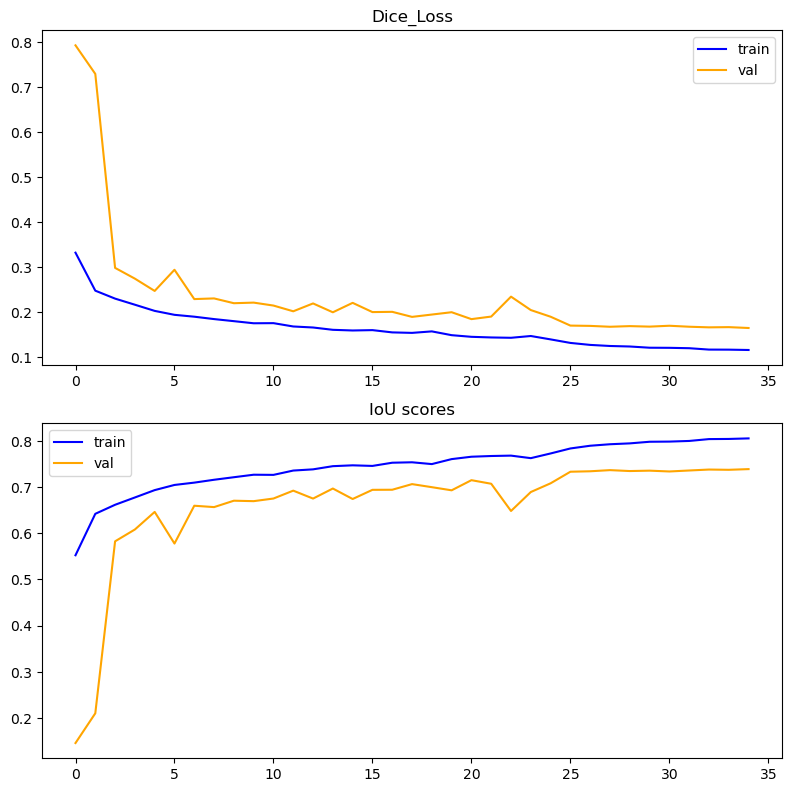

In [20]:
summarize_diagnostics(history)

In [21]:
model = keras.models.load_model(
    f"models/{model_name}.keras", 
    custom_objects={
        'iou_score':sm.metrics.iou_score, 
        'f1-score':sm.metrics.f1_score, 
        'dice_loss':sm.losses.DiceLoss() })

In [28]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 6s 91ms/step - loss: 0.1651 - iou_score: 0.7387 - f1-score: 0.8348
inference time (500 samples): 5.87s


### Test de prédiction

In [29]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [30]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 0s 35ms/step
Inference time: 0.07s


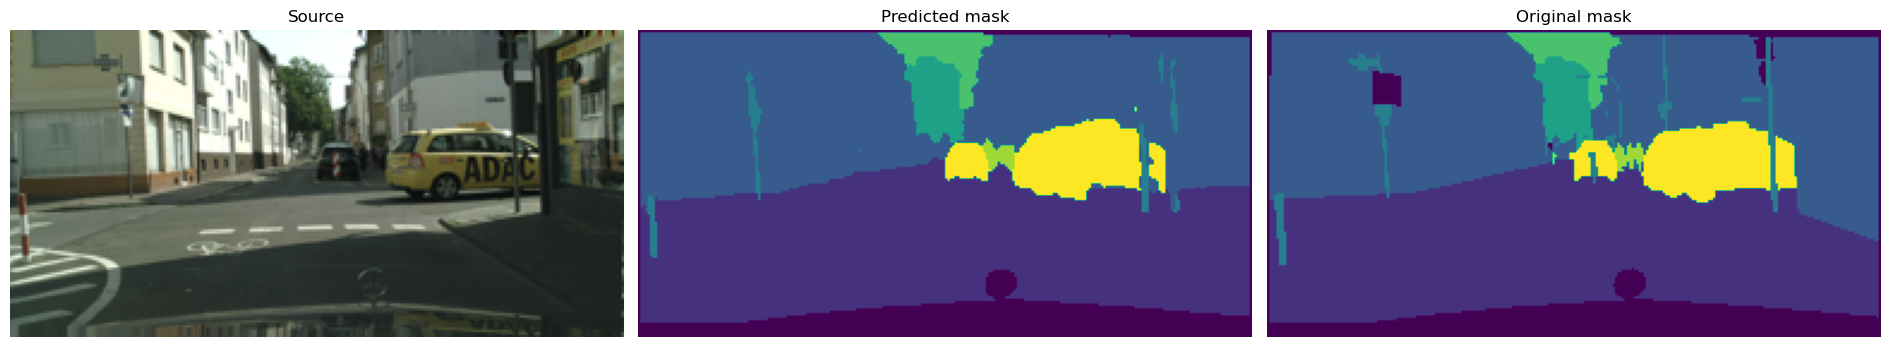

In [31]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [32]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [33]:
scorer.show_scores()

IoU      Dice  \
U-Net_baseline                                      0.552171  0.667224   
U-Net_baseline_with_data_augmentation_1             0.564558  0.680571   
U-Net_baseline_with_data_augmentation_2             0.559365  0.674603   
U-Net_baseline_with_data_augmentation_3             0.117844  0.197346   
U-Net_baseline_with_data_augmentation_2_diceLoss    0.631681  0.743959   
U-Net_baseline_with_data_augmentation_2_diceLos...  0.612228  0.728071   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.486711  0.612405   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.454141  0.585703   
U-Net_baseline_with_data_augmentation_2_cceDice...  0.622789  0.738499   
U-Net_baseline_with_data_augmentation_2_cceDice...  0.628407  0.742861   
U-Net-resetnet152_with_data_augmentation_2_dice...  0.722085  0.822108   
U-Net-vgg19_with_data_augmentation_2_diceLoss       0.734644  0.832938   
U-Net-resnext101_with_data_augmentation_2_diceLoss  0.720611  0.820914   
FPN-resnet152_with_data_augmentation_2_diceLoss     0.738715  0.834818   

                                                    training_time  \
U-Net_baseline                                         517.575655   
U-Net_baseline_with_data_augmentation_1               1029.694759   
U-Net_baseline_with_data_augmentation_2                714.297488   
U-Net_baseline_with_data_augmentation_3                284.685457   
U-Net_baseline_with_data_augmentation_2_diceLoss       843.582155   
U-Net_baseline_with_data_augmentation_2_diceLos...     697.217847   
U-Net_baseline_with_data_augmentation_2_focalLo...     326.424069   
U-Net_baseline_with_data_augmentation_2_focalLo...     318.810731   
U-Net_baseline_with_data_augmentation_2_cceDice...     899.124581   
U-Net_baseline_with_data_augmentation_2_cceDice...     995.207425   
U-Net-resetnet152_with_data_augmentation_2_dice...    3538.612212   
U-Net-vgg19_with_data_augmentation_2_diceLoss         1932.282903   
U-Net-resnext101_with_data_augmentation_2_diceLoss    3738.743413   
FPN-resnet152_with_data_augmentation_2_diceLoss       4316.767552   

                                                    inference_time_500  \
U-Net_baseline                                                1.851263   
U-Net_baseline_with_data_augmentation_1                       2.369722   
U-Net_baseline_with_data_augmentation_2                       2.345822   
U-Net_baseline_with_data_augmentation_3                       2.193978   
U-Net_baseline_with_data_augmentation_2_diceLoss              2.138717   
U-Net_baseline_with_data_augmentation_2_diceLos...            2.189904   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.646039   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.206589   
U-Net_baseline_with_data_augmentation_2_cceDice...            2.216438   
U-Net_baseline_with_data_augmentation_2_cceDice...            2.260605   
U-Net-resetnet152_with_data_augmentation_2_dice...            6.312516   
U-Net-vgg19_with_data_augmentation_2_diceLoss                 3.101655   
U-Net-resnext101_with_data_augmentation_2_diceLoss            5.380407   
FPN-resnet152_with_data_augmentation_2_diceLoss               5.874191   

                                                    inference_time_1  
U-Net_baseline                                              0.895139  
U-Net_baseline_with_data_augmentation_1                     0.423762  
U-Net_baseline_with_data_augmentation_2                     0.924520  
U-Net_baseline_with_data_augmentation_3                     0.414083  
U-Net_baseline_with_data_augmentation_2_diceLoss            0.903396  
U-Net_baseline_with_data_augmentation_2_diceLos...          0.415433  
U-Net_baseline_with_data_augmentation_2_focalLo...          0.425659  
U-Net_baseline_with_data_augmentation_2_focalLo...          0.418523  
U-Net_baseline_with_data_augmentation_2_cceDice...          0.415926  
U-Net_baseline_with_data_augmentation_2_cceDice...          0.444320  
U-Net-resetnet152_

## 5.5 FPN sur un backbone EfficientnetB7 <a class="anchor" id="archi5"></a> [⇪](#menu)

### Définissons un pré-processing

In [35]:
BACKBONE = 'efficientnetb7'
preprocess_input = sm.get_preprocessing(BACKBONE)

### Préparons les training et validation sets **avec** data-augmentation

In [36]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transform2,
    preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Définissons et entrainons un modèle

In [37]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = sm.losses.DiceLoss() 
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = sm.FPN(BACKBONE, encoder_weights='imagenet', classes=8, activation='softmax')
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

258434480/258434480 [==============================] - 2s 0us/step


In [38]:
model_name = "FPN-efficientnetb7_with_data_augmentation_2_diceLoss"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.2654 - iou_score: 0.6225 - f1-score: 0.7347
Epoch 1: val_iou_score improved from -inf to 0.28523, saving model to models/FPN-efficientnetb7_with_data_augmentation_2_diceLoss.keras
372/372 [==============================] - 223s 517ms/step - loss: 0.2654 - iou_score: 0.6225 - f1-score: 0.7347 - val_loss: 0.6219 - val_iou_score: 0.2852 - val_f1-score: 0.3776 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.1967 - iou_score: 0.6988 - f1-score: 0.8033
Epoch 2: val_iou_score improved from 0.28523 to 0.65571, saving model to models/FPN-efficientnetb7_with_data_augmentation_2_diceLoss.keras
372/372 [==============================] - 192s 517ms/step - loss: 0.1967 - iou_score: 0.6988 - f1-score: 0.8033 - val_loss: 0.2286 - val_iou_score: 0.6557 - val_f1-score: 0.7718 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.1783 - iou_score: 0.7214 -

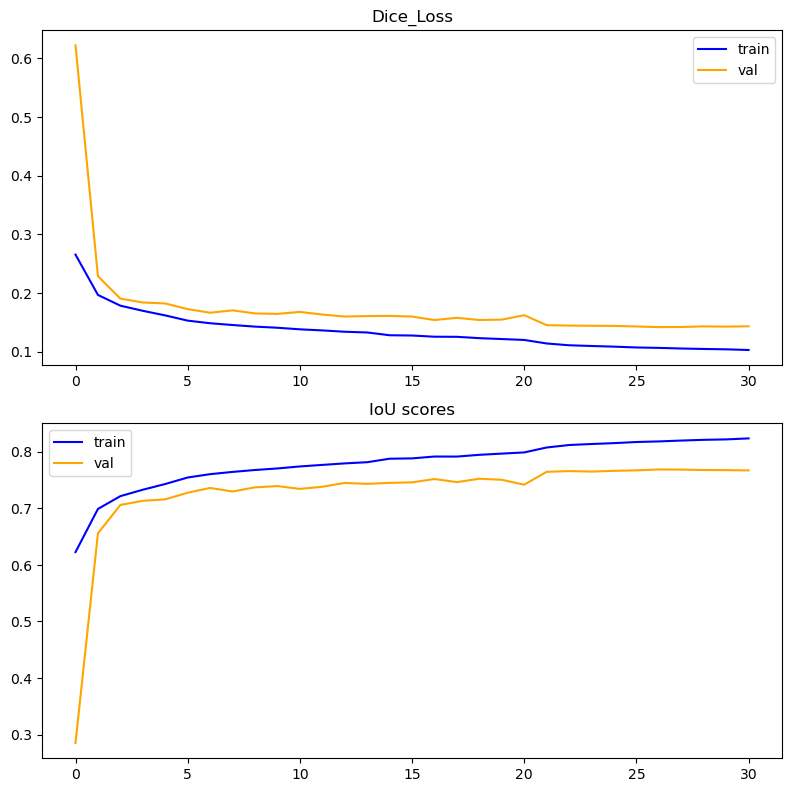

In [39]:
summarize_diagnostics(history)

In [40]:
model = keras.models.load_model(
    f"models/{model_name}.keras", 
    custom_objects={
        'iou_score':sm.metrics.iou_score, 
        'f1-score':sm.metrics.f1_score, 
        'dice_loss':sm.losses.DiceLoss() })

In [47]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 7s 114ms/step - loss: 0.1425 - iou_score: 0.7685 - f1-score: 0.8580
inference time (500 samples): 7.30s


### Test de prédiction

In [48]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [49]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 0s 46ms/step
Inference time: 0.08s


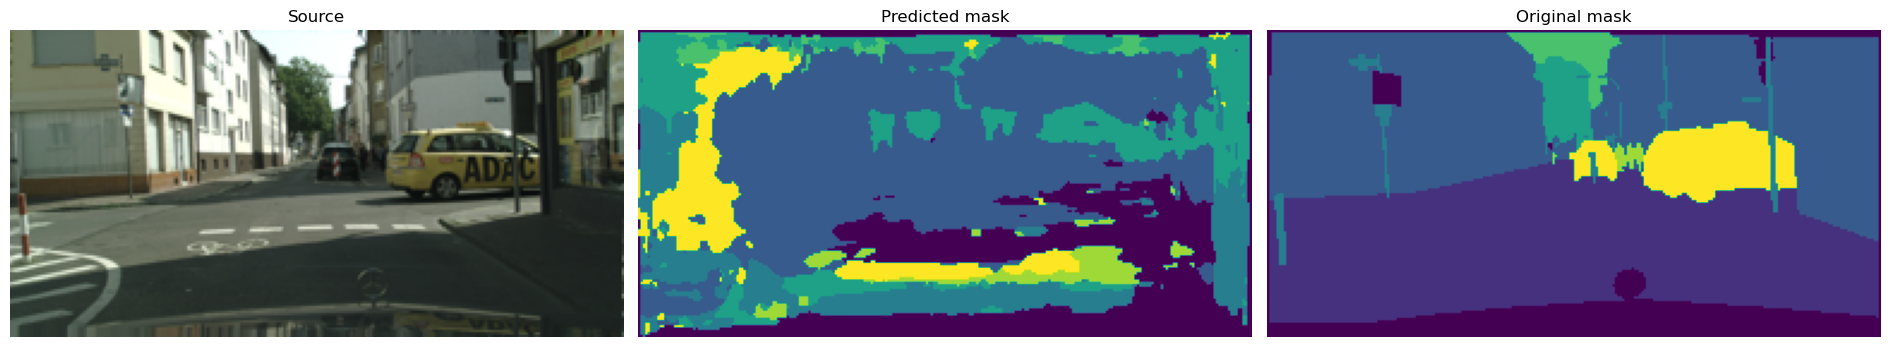

In [50]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [51]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [52]:
scorer.show_scores()

IoU      Dice  \
U-Net_baseline                                      0.552171  0.667224   
U-Net_baseline_with_data_augmentation_1             0.564558  0.680571   
U-Net_baseline_with_data_augmentation_2             0.559365  0.674603   
U-Net_baseline_with_data_augmentation_3             0.117844  0.197346   
U-Net_baseline_with_data_augmentation_2_diceLoss    0.631681  0.743959   
U-Net_baseline_with_data_augmentation_2_diceLos...  0.612228  0.728071   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.486711  0.612405   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.454141  0.585703   
U-Net_baseline_with_data_augmentation_2_cceDice...  0.622789  0.738499   
U-Net_baseline_with_data_augmentation_2_cceDice...  0.628407  0.742861   
U-Net-resetnet152_with_data_augmentation_2_dice...  0.722085  0.822108   
U-Net-vgg19_with_data_augmentation_2_diceLoss       0.734644  0.832938   
U-Net-resnext101_with_data_augmentation_2_diceLoss  0.720611  0.820914   
FPN-resnet152_with_data_augmentation_2_diceLoss     0.738715  0.834818   
FPN-efficientnetb7_with_data_augmentation_2_dic...  0.768454  0.858004   

                                                    training_time  \
U-Net_baseline                                         517.575655   
U-Net_baseline_with_data_augmentation_1               1029.694759   
U-Net_baseline_with_data_augmentation_2                714.297488   
U-Net_baseline_with_data_augmentation_3                284.685457   
U-Net_baseline_with_data_augmentation_2_diceLoss       843.582155   
U-Net_baseline_with_data_augmentation_2_diceLos...     697.217847   
U-Net_baseline_with_data_augmentation_2_focalLo...     326.424069   
U-Net_baseline_with_data_augmentation_2_focalLo...     318.810731   
U-Net_baseline_with_data_augmentation_2_cceDice...     899.124581   
U-Net_baseline_with_data_augmentation_2_cceDice...     995.207425   
U-Net-resetnet152_with_data_augmentation_2_dice...    3538.612212   
U-Net-vgg19_with_data_augmentation_2_diceLoss         1932.282903   
U-Net-resnext101_with_data_augmentation_2_diceLoss    3738.743413   
FPN-resnet152_with_data_augmentation_2_diceLoss       4316.767552   
FPN-efficientnetb7_with_data_augmentation_2_dic...    5930.868126   

                                                    inference_time_500  \
U-Net_baseline                                                1.851263   
U-Net_baseline_with_data_augmentation_1                       2.369722   
U-Net_baseline_with_data_augmentation_2                       2.345822   
U-Net_baseline_with_data_augmentation_3                       2.193978   
U-Net_baseline_with_data_augmentation_2_diceLoss              2.138717   
U-Net_baseline_with_data_augmentation_2_diceLos...            2.189904   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.646039   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.206589   
U-Net_baseline_with_data_augmentation_2_cceDice...            2.216438   
U-Net_baseline_with_data_augmentation_2_cceDice...            2.260605   
U-Net-resetnet152_with_data_augmentation_2_dice...            6.312516   
U-Net-vgg19_with_data_augmentation_2_diceLoss                 3.101655   
U-Net-resnext101_with_data_augmentation_2_diceLoss            5.380407   
FPN-resnet152_with_data_augmentation_2_diceLoss               5.874191   
FPN-efficientnetb7_with_data_augmentation_2_dic...            7.299468   

                                                    inference_time_1  
U-Net_baseline                                              0.895139  
U-Net_baseline_with_data_augmentation_1                     0.423762  
U-Net_baseline_with_data_augmentation_2                     0.924520  
U-Net_baseline_with_data_augmentation_3                     0.414083  
U-Net_baseline_with_data_augmentation_2_diceLoss            0.903396  
U-Net_baseline_with_data_augmentation_2_diceLos...          0.415433  
U-Net_baseline_with_data_augmentation_2_focalLo...          0.425659  
U-Net_baseline

## 5.6 FPN sur un backbone VGG19 <a class="anchor" id="archi6"></a> [⇪](#menu)

### Définissons un pré-processing

In [53]:
BACKBONE = 'vgg19'
preprocess_input = sm.get_preprocessing(BACKBONE)

### Préparons les training et validation sets **avec** data-augmentation

In [54]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transform2,
    preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Définissons et entrainons un modèle

In [55]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = sm.losses.DiceLoss() 
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = sm.FPN(BACKBONE, encoder_weights='imagenet', classes=8, activation='softmax')
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [56]:
model_name = "FPN-vgg19_with_data_augmentation_2_diceLoss"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.3149 - iou_score: 0.5670 - f1-score: 0.6852
Epoch 1: val_iou_score improved from -inf to 0.58453, saving model to models/FPN-vgg19_with_data_augmentation_2_diceLoss.keras
372/372 [==============================] - 92s 238ms/step - loss: 0.3149 - iou_score: 0.5670 - f1-score: 0.6852 - val_loss: 0.2888 - val_iou_score: 0.5845 - val_f1-score: 0.7105 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.2401 - iou_score: 0.6466 - f1-score: 0.7599
Epoch 2: val_iou_score improved from 0.58453 to 0.63631, saving model to models/FPN-vgg19_with_data_augmentation_2_diceLoss.keras
372/372 [==============================] - 89s 238ms/step - loss: 0.2401 - iou_score: 0.6466 - f1-score: 0.7599 - val_loss: 0.2484 - val_iou_score: 0.6363 - val_f1-score: 0.7509 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.2166 - iou_score: 0.6749 - f1-score: 0.7834
Ep

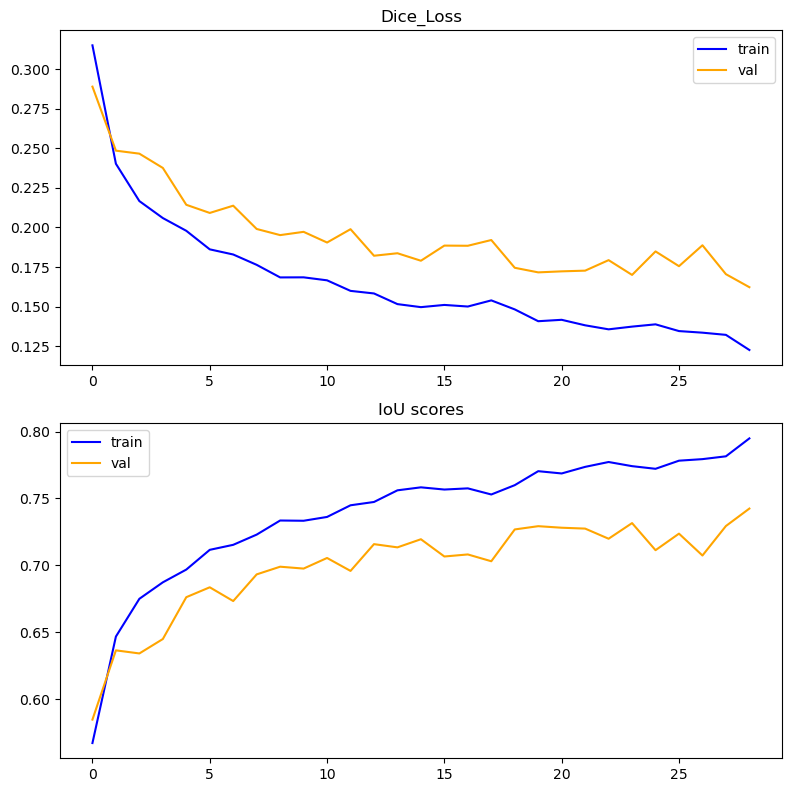

In [57]:
summarize_diagnostics(history)

In [58]:
model = keras.models.load_model(
    f"models/{model_name}.keras", 
    custom_objects={
        'iou_score':sm.metrics.iou_score, 
        'f1-score':sm.metrics.f1_score, 
        'dice_loss':sm.losses.DiceLoss() })

In [59]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 5s 78ms/step - loss: 0.1602 - iou_score: 0.7445 - f1-score: 0.8397
inference time (500 samples): 5.41s


### Test de prédiction

In [60]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [61]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 1s 695ms/step
Inference time: 0.72s


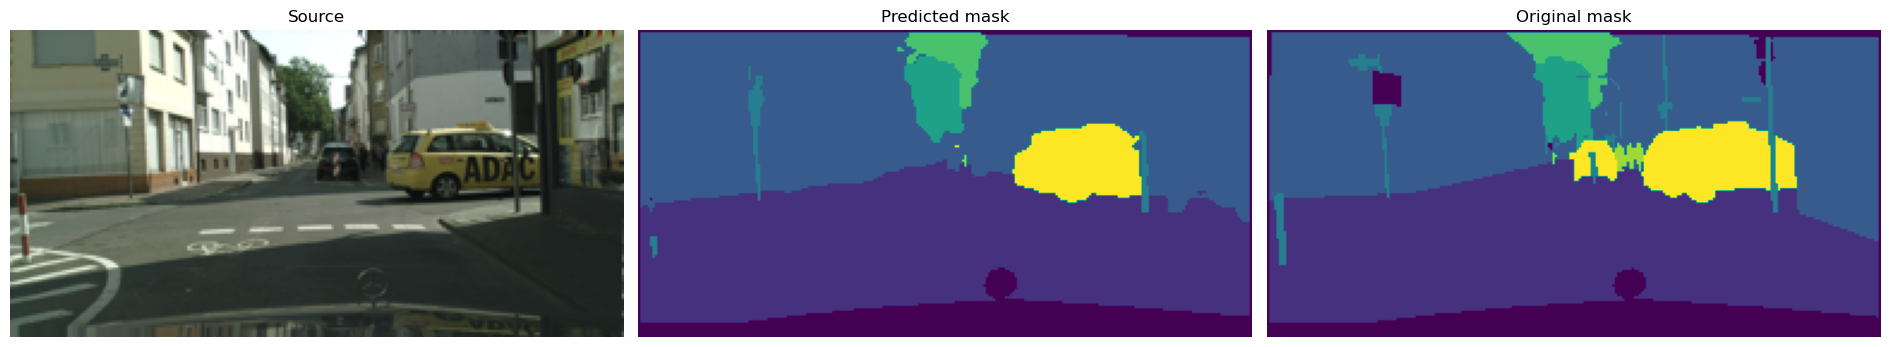

In [62]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [63]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [64]:
scorer.show_scores()

IoU      Dice  \
U-Net_baseline                                      0.552171  0.667224   
U-Net_baseline_with_data_augmentation_1             0.564558  0.680571   
U-Net_baseline_with_data_augmentation_2             0.559365  0.674603   
U-Net_baseline_with_data_augmentation_3             0.117844  0.197346   
U-Net_baseline_with_data_augmentation_2_diceLoss    0.631681  0.743959   
U-Net_baseline_with_data_augmentation_2_diceLos...  0.612228  0.728071   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.486711  0.612405   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.454141  0.585703   
U-Net_baseline_with_data_augmentation_2_cceDice...  0.622789  0.738499   
U-Net_baseline_with_data_augmentation_2_cceDice...  0.628407  0.742861   
U-Net-resetnet152_with_data_augmentation_2_dice...  0.722085  0.822108   
U-Net-vgg19_with_data_augmentation_2_diceLoss       0.734644  0.832938   
U-Net-resnext101_with_data_augmentation_2_diceLoss  0.720611  0.820914   
FPN-resnet152_with_data_augmentation_2_diceLoss     0.738715  0.834818   
FPN-efficientnetb7_with_data_augmentation_2_dic...  0.768454  0.858004   
FPN-vgg19_with_data_augmentation_2_diceLoss         0.744457  0.839688   

                                                    training_time  \
U-Net_baseline                                         517.575655   
U-Net_baseline_with_data_augmentation_1               1029.694759   
U-Net_baseline_with_data_augmentation_2                714.297488   
U-Net_baseline_with_data_augmentation_3                284.685457   
U-Net_baseline_with_data_augmentation_2_diceLoss       843.582155   
U-Net_baseline_with_data_augmentation_2_diceLos...     697.217847   
U-Net_baseline_with_data_augmentation_2_focalLo...     326.424069   
U-Net_baseline_with_data_augmentation_2_focalLo...     318.810731   
U-Net_baseline_with_data_augmentation_2_cceDice...     899.124581   
U-Net_baseline_with_data_augmentation_2_cceDice...     995.207425   
U-Net-resetnet152_with_data_augmentation_2_dice...    3538.612212   
U-Net-vgg19_with_data_augmentation_2_diceLoss         1932.282903   
U-Net-resnext101_with_data_augmentation_2_diceLoss    3738.743413   
FPN-resnet152_with_data_augmentation_2_diceLoss       4316.767552   
FPN-efficientnetb7_with_data_augmentation_2_dic...    5930.868126   
FPN-vgg19_with_data_augmentation_2_diceLoss           2601.794258   

                                                    inference_time_500  \
U-Net_baseline                                                1.851263   
U-Net_baseline_with_data_augmentation_1                       2.369722   
U-Net_baseline_with_data_augmentation_2                       2.345822   
U-Net_baseline_with_data_augmentation_3                       2.193978   
U-Net_baseline_with_data_augmentation_2_diceLoss              2.138717   
U-Net_baseline_with_data_augmentation_2_diceLos...            2.189904   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.646039   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.206589   
U-Net_baseline_with_data_augmentation_2_cceDice...            2.216438   
U-Net_baseline_with_data_augmentation_2_cceDice...            2.260605   
U-Net-resetnet152_with_data_augmentation_2_dice...            6.312516   
U-Net-vgg19_with_data_augmentation_2_diceLoss                 3.101655   
U-Net-resnext101_with_data_augmentation_2_diceLoss            5.380407   
FPN-resnet152_with_data_augmentation_2_diceLoss               5.874191   
FPN-efficientnetb7_with_data_augmentation_2_dic...            7.299468   
FPN-vgg19_with_data_augmentation_2_diceLoss                   5.406630   

                                                    inference_time_1  
U-Net_baseline                                              0.895139  
U-Net_baseline_with_data_augmentation_1                     0.423762  
U-Net_baseline_with_data_augmentation_2                     0.924520  
U-Net_baseline_with_data_augmentation_3                     0.414083  
U-Net_base

## 5.7 U-Net custom (mini) <a class="anchor" id="archi7"></a> [⇪](#menu)

In [16]:
# From "Deep Learning with Python 2nd edition" page 244
def get_model3(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    
    x = layers.Conv2D(64,  3, activation="relu", padding="same", strides=2)(inputs)
    x = layers.Conv2D(64,  3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    
    x = layers.Conv2DTranspose(256, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(256, 3, activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(64,  3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64,  3, activation='relu', padding='same', strides=2)(x)
    
    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

### Préparons les training et validation sets **avec** data-augmentation

In [17]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transform2,
    preprocessing=None, #preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    preprocessing=None, #preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Définissons et entrainons un modèle

In [18]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = sm.losses.DiceLoss() 
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = get_model3((128,256), 8)
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [20]:
model_name = "U-Net-custom_with_data_augmentation_2_diceLoss"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.6687 - iou_score: 0.2367 - f1-score: 0.3313
Epoch 1: val_iou_score improved from -inf to 0.28847, saving model to models/U-Net-custom_with_data_augmentation_2_diceLoss.keras
372/372 [==============================] - 28s 75ms/step - loss: 0.6687 - iou_score: 0.2367 - f1-score: 0.3313 - val_loss: 0.6078 - val_iou_score: 0.2885 - val_f1-score: 0.3918 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.5869 - iou_score: 0.3132 - f1-score: 0.4131
Epoch 2: val_iou_score improved from 0.28847 to 0.30935, saving model to models/U-Net-custom_with_data_augmentation_2_diceLoss.keras
372/372 [==============================] - 25s 67ms/step - loss: 0.5869 - iou_score: 0.3132 - f1-score: 0.4131 - val_loss: 0.5886 - val_iou_score: 0.3094 - val_f1-score: 0.4114 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.5682 - iou_score: 0.3314 - f1-score: 0.431

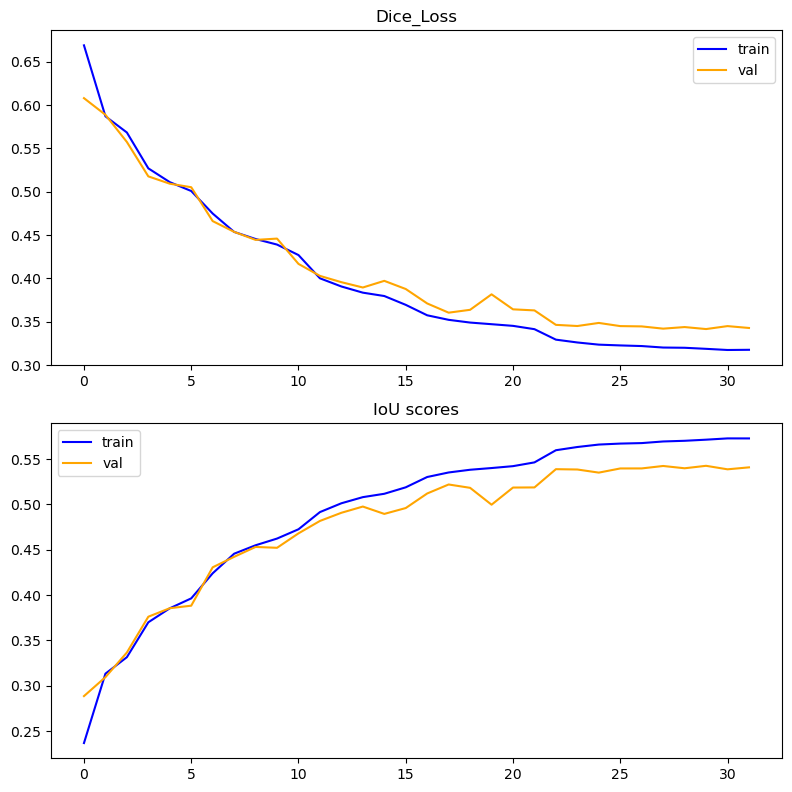

In [21]:
summarize_diagnostics(history)

In [22]:
model = keras.models.load_model(
    f"models/{model_name}.keras", 
    custom_objects={
        'iou_score':sm.metrics.iou_score, 
        'f1-score':sm.metrics.f1_score, 
        'dice_loss':sm.losses.DiceLoss() })

In [23]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 2s 27ms/step - loss: 0.3423 - iou_score: 0.5418 - f1-score: 0.6577
inference time (500 samples): 2.00s


### Test de prédiction

In [24]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [25]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 1s 621ms/step
Inference time: 0.65s


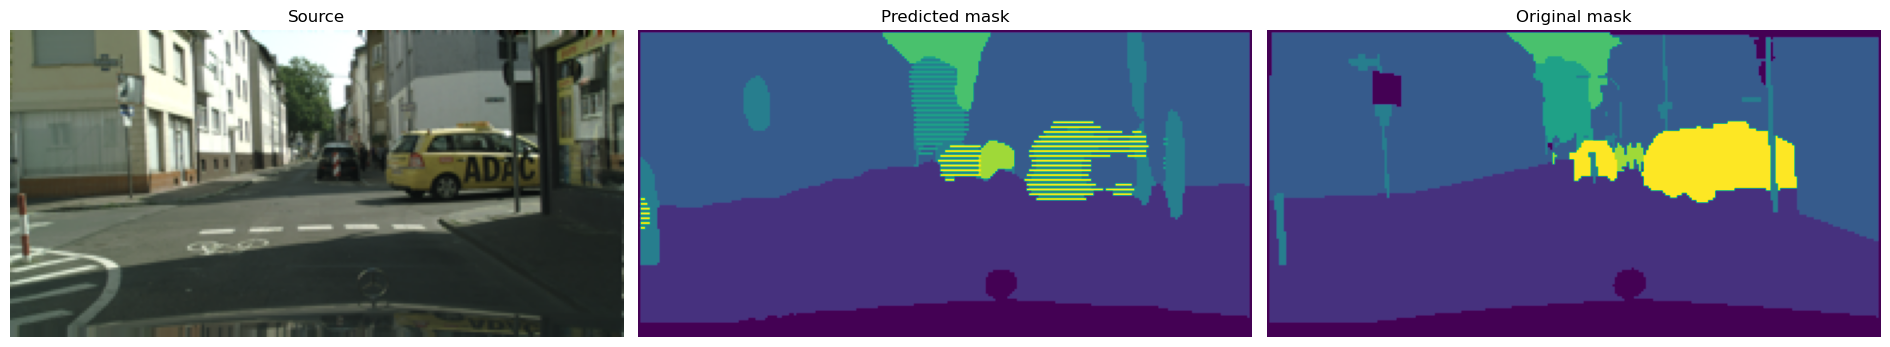

In [26]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [27]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [28]:
scorer.show_scores()

IoU      Dice  \
U-Net_baseline                                      0.552171  0.667224   
U-Net_baseline_with_data_augmentation_1             0.564558  0.680571   
U-Net_baseline_with_data_augmentation_2             0.559365  0.674603   
U-Net_baseline_with_data_augmentation_3             0.117844  0.197346   
U-Net_baseline_with_data_augmentation_2_diceLoss    0.631681  0.743959   
U-Net_baseline_with_data_augmentation_2_diceLos...  0.612228  0.728071   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.486711  0.612405   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.454141  0.585703   
U-Net_baseline_with_data_augmentation_2_cceDice...  0.622789  0.738499   
U-Net_baseline_with_data_augmentation_2_cceDice...  0.628407  0.742861   
U-Net-resetnet152_with_data_augmentation_2_dice...  0.722085  0.822108   
U-Net-vgg19_with_data_augmentation_2_diceLoss       0.734644  0.832938   
U-Net-resnext101_with_data_augmentation_2_diceLoss  0.720611  0.820914   
FPN-resnet152_with_data_augmentation_2_diceLoss     0.738715  0.834818   
FPN-efficientnetb7_with_data_augmentation_2_dic...  0.768454  0.858004   
FPN-vgg19_with_data_augmentation_2_diceLoss         0.744457  0.839688   
U-Net-custom_with_data_augmentation_2_diceLoss      0.541770  0.657728   

                                                    training_time  \
U-Net_baseline                                         517.575655   
U-Net_baseline_with_data_augmentation_1               1029.694759   
U-Net_baseline_with_data_augmentation_2                714.297488   
U-Net_baseline_with_data_augmentation_3                284.685457   
U-Net_baseline_with_data_augmentation_2_diceLoss       843.582155   
U-Net_baseline_with_data_augmentation_2_diceLos...     697.217847   
U-Net_baseline_with_data_augmentation_2_focalLo...     326.424069   
U-Net_baseline_with_data_augmentation_2_focalLo...     318.810731   
U-Net_baseline_with_data_augmentation_2_cceDice...     899.124581   
U-Net_baseline_with_data_augmentation_2_cceDice...     995.207425   
U-Net-resetnet152_with_data_augmentation_2_dice...    3538.612212   
U-Net-vgg19_with_data_augmentation_2_diceLoss         1932.282903   
U-Net-resnext101_with_data_augmentation_2_diceLoss    3738.743413   
FPN-resnet152_with_data_augmentation_2_diceLoss       4316.767552   
FPN-efficientnetb7_with_data_augmentation_2_dic...    5930.868126   
FPN-vgg19_with_data_augmentation_2_diceLoss           2601.794258   
U-Net-custom_with_data_augmentation_2_diceLoss         820.391873   

                                                    inference_time_500  \
U-Net_baseline                                                1.851263   
U-Net_baseline_with_data_augmentation_1                       2.369722   
U-Net_baseline_with_data_augmentation_2                       2.345822   
U-Net_baseline_with_data_augmentation_3                       2.193978   
U-Net_baseline_with_data_augmentation_2_diceLoss              2.138717   
U-Net_baseline_with_data_augmentation_2_diceLos...            2.189904   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.646039   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.206589   
U-Net_baseline_with_data_augmentation_2_cceDice...            2.216438   
U-Net_baseline_with_data_augmentation_2_cceDice...            2.260605   
U-Net-resetnet152_with_data_augmentation_2_dice...            6.312516   
U-Net-vgg19_with_data_augmentation_2_diceLoss                 3.101655   
U-Net-resnext101_with_data_augmentation_2_diceLoss            5.380407   
FPN-resnet152_with_data_augmentation_2_diceLoss               5.874191   
FPN-efficientnetb7_with_data_augmentation_2_dic...            7.299468   
FPN-vgg19_with_data_augmentation_2_diceLoss                   5.406630   
U-Net-custom_with_data_augmentation_2_diceLoss                1.998511   

                                                    inference_time_1  
U-Net_baseline                                              0.895139  
U-Net_

## 5.8 LinkNet sur un backbone resnet152 <a class="anchor" id="archi8"></a> [⇪](#menu)

### Définissons un pré-processing

In [28]:
BACKBONE = 'resnet152'
preprocess_input = sm.get_preprocessing(BACKBONE)

### Préparons les training et validation sets **avec** data-augmentation

In [29]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transform2,
    preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Définissons et entrainons un modèle

In [31]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = sm.losses.DiceLoss() 
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = sm.Linknet(BACKBONE, encoder_weights='imagenet', classes=8, activation='softmax')
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [32]:
model_name = "LinkNet-resnet152_with_data_augmentation_2_diceLoss"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.4351 - iou_score: 0.4527 - f1-score: 0.5647
Epoch 1: val_iou_score improved from -inf to 0.16408, saving model to models/LinkNet-resnet152_with_data_augmentation_2_diceLoss.keras
372/372 [==============================] - 113s 258ms/step - loss: 0.4351 - iou_score: 0.4527 - f1-score: 0.5647 - val_loss: 0.7759 - val_iou_score: 0.1641 - val_f1-score: 0.2239 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.2835 - iou_score: 0.6020 - f1-score: 0.7165
Epoch 2: val_iou_score improved from 0.16408 to 0.17212, saving model to models/LinkNet-resnet152_with_data_augmentation_2_diceLoss.keras
372/372 [==============================] - 96s 257ms/step - loss: 0.2835 - iou_score: 0.6020 - f1-score: 0.7165 - val_loss: 0.7691 - val_iou_score: 0.1721 - val_f1-score: 0.2309 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.2556 - iou_score: 0.6308 - f1

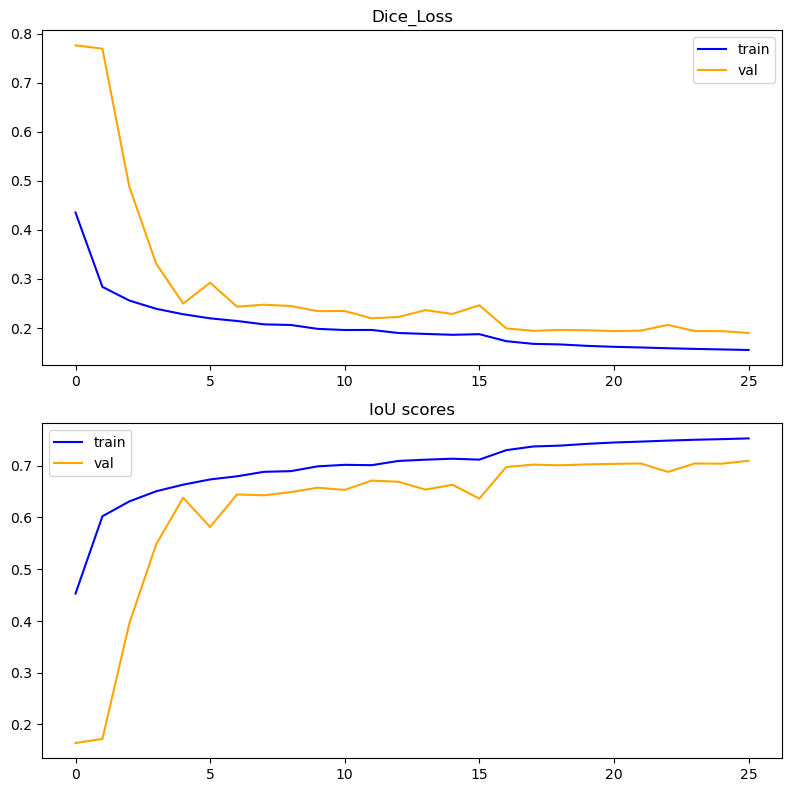

In [33]:
summarize_diagnostics(history)

In [34]:
model = keras.models.load_model(
    f"models/{model_name}.keras", 
    custom_objects={
        'iou_score':sm.metrics.iou_score, 
        'f1-score':sm.metrics.f1_score, 
        'dice_loss':sm.losses.DiceLoss() })

In [35]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 7s 65ms/step - loss: 0.1908 - iou_score: 0.7076 - f1-score: 0.8093
inference time (500 samples): 6.77s


### Test de prédiction

In [36]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [37]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 3s 3s/step
Inference time: 3.06s


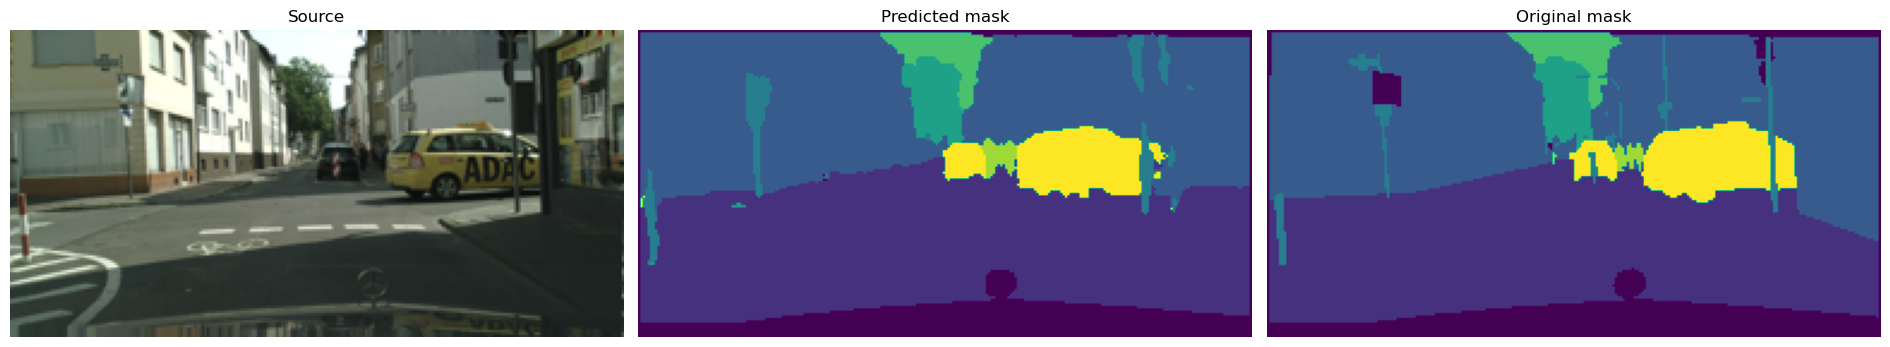

In [38]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [39]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [40]:
scorer.show_scores()

IoU      Dice  \
U-Net_baseline                                      0.552171  0.667224   
U-Net_baseline_with_data_augmentation_1             0.564558  0.680571   
U-Net_baseline_with_data_augmentation_2             0.559365  0.674603   
U-Net_baseline_with_data_augmentation_3             0.117844  0.197346   
U-Net_baseline_with_data_augmentation_2_diceLoss    0.631681  0.743959   
U-Net_baseline_with_data_augmentation_2_diceLos...  0.612228  0.728071   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.486711  0.612405   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.454141  0.585703   
U-Net_baseline_with_data_augmentation_2_cceDice...  0.622789  0.738499   
U-Net_baseline_with_data_augmentation_2_cceDice...  0.628407  0.742861   
U-Net-resetnet152_with_data_augmentation_2_dice...  0.722085  0.822108   
U-Net-vgg19_with_data_augmentation_2_diceLoss       0.734644  0.832938   
U-Net-resnext101_with_data_augmentation_2_diceLoss  0.720611  0.820914   
FPN-resnet152_with_data_augmentation_2_diceLoss     0.738715  0.834818   
FPN-efficientnetb7_with_data_augmentation_2_dic...  0.768454  0.858004   
FPN-vgg19_with_data_augmentation_2_diceLoss         0.744457  0.839688   
U-Net-custom_with_data_augmentation_2_diceLoss      0.541770  0.657728   
LinkNet-resnet152_with_data_augmentation_2_dice...  0.707575  0.809275   

                                                    training_time  \
U-Net_baseline                                         517.575655   
U-Net_baseline_with_data_augmentation_1               1029.694759   
U-Net_baseline_with_data_augmentation_2                714.297488   
U-Net_baseline_with_data_augmentation_3                284.685457   
U-Net_baseline_with_data_augmentation_2_diceLoss       843.582155   
U-Net_baseline_with_data_augmentation_2_diceLos...     697.217847   
U-Net_baseline_with_data_augmentation_2_focalLo...     326.424069   
U-Net_baseline_with_data_augmentation_2_focalLo...     318.810731   
U-Net_baseline_with_data_augmentation_2_cceDice...     899.124581   
U-Net_baseline_with_data_augmentation_2_cceDice...     995.207425   
U-Net-resetnet152_with_data_augmentation_2_dice...    3538.612212   
U-Net-vgg19_with_data_augmentation_2_diceLoss         1932.282903   
U-Net-resnext101_with_data_augmentation_2_diceLoss    3738.743413   
FPN-resnet152_with_data_augmentation_2_diceLoss       4316.767552   
FPN-efficientnetb7_with_data_augmentation_2_dic...    5930.868126   
FPN-vgg19_with_data_augmentation_2_diceLoss           2601.794258   
U-Net-custom_with_data_augmentation_2_diceLoss         820.391873   
LinkNet-resnet152_with_data_augmentation_2_dice...    2433.885920   

                                                    inference_time_500  \
U-Net_baseline                                                1.851263   
U-Net_baseline_with_data_augmentation_1                       2.369722   
U-Net_baseline_with_data_augmentation_2                       2.345822   
U-Net_baseline_with_data_augmentation_3                       2.193978   
U-Net_baseline_with_data_augmentation_2_diceLoss              2.138717   
U-Net_baseline_with_data_augmentation_2_diceLos...            2.189904   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.646039   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.206589   
U-Net_baseline_with_data_augmentation_2_cceDice...            2.216438   
U-Net_baseline_with_data_augmentation_2_cceDice...            2.260605   
U-Net-resetnet152_with_data_augmentation_2_dice...            6.312516   
U-Net-vgg19_with_data_augmentation_2_diceLoss                 3.101655   
U-Net-resnext101_with_data_augmentation_2_diceLoss            5.380407   
FPN-resnet152_with_data_augmentation_2_diceLoss               5.874191   
FPN-efficientnetb7_with_data_augmentation_2_dic...            7.299468   
FPN-vgg19_with_data_augmentation_2_diceLoss                   5.406630   
U-Net-custom_with_data_augmentation_2_diceLoss                1.998511   
LinkNe

## 5.9 LinkNet sur un backbone efficientnetB7 <a class="anchor" id="archi9"></a> [⇪](#menu)

### Définissons un pré-processing

In [16]:
BACKBONE = 'efficientnetb7'
preprocess_input = sm.get_preprocessing(BACKBONE)

### Préparons les training et validation sets **avec** data-augmentation

In [17]:
batch_size = 8

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transform2,
    preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    # maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Définissons et entrainons un modèle

In [18]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = sm.losses.DiceLoss() 
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]

model = sm.Linknet(BACKBONE, encoder_weights='imagenet', classes=8, activation='softmax')
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [20]:
model_name = "LinkNet-efficientnetb7_with_data_augmentation_2_diceLoss"
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    batch_size=batch_size,
    callbacks=init_callbacks(model_name),
    # validation_split=0.2
)
training_time = time.perf_counter() - t0

Epoch 1/100
372/372 [==============================] - ETA: 0s - loss: 0.3444 - iou_score: 0.5459 - f1-score: 0.6557
Epoch 1: val_iou_score improved from -inf to 0.31246, saving model to models/LinkNet-efficientnetb7_with_data_augmentation_2_diceLoss.keras
372/372 [==============================] - 175s 468ms/step - loss: 0.3444 - iou_score: 0.5459 - f1-score: 0.6557 - val_loss: 0.5948 - val_iou_score: 0.3125 - val_f1-score: 0.4051 - lr: 5.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 0.2089 - iou_score: 0.6850 - f1-score: 0.7911
Epoch 2: val_iou_score improved from 0.31246 to 0.64450, saving model to models/LinkNet-efficientnetb7_with_data_augmentation_2_diceLoss.keras
372/372 [==============================] - 171s 461ms/step - loss: 0.2089 - iou_score: 0.6850 - f1-score: 0.7911 - val_loss: 0.2399 - val_iou_score: 0.6445 - val_f1-score: 0.7600 - lr: 5.0000e-04
Epoch 3/100
372/372 [==============================] - ETA: 0s - loss: 0.1901 - iou_score: 

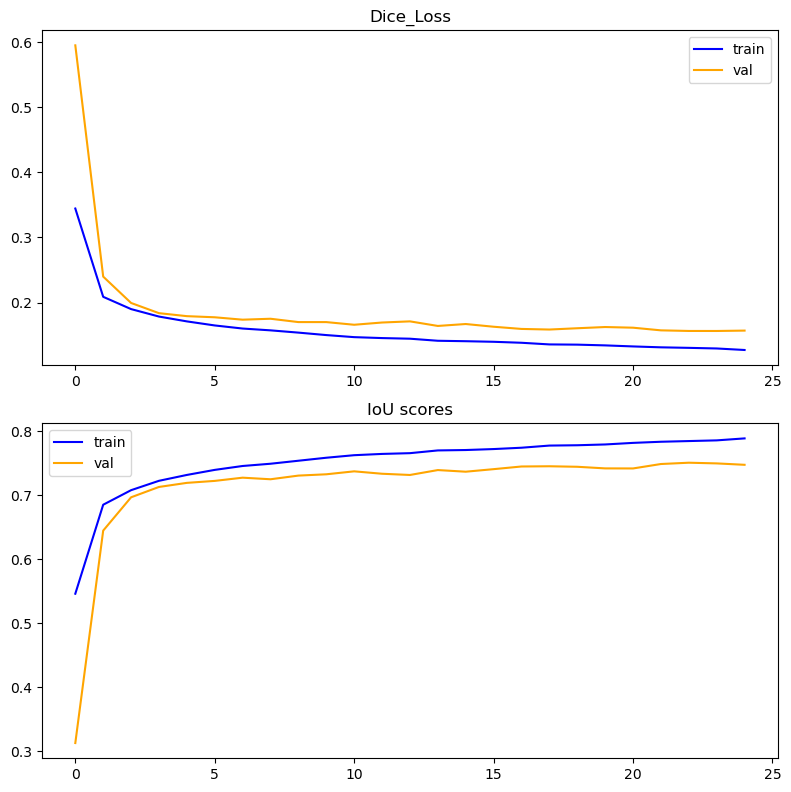

In [21]:
summarize_diagnostics(history)

In [22]:
model = keras.models.load_model(
    f"models/{model_name}.keras", 
    custom_objects={
        'iou_score':sm.metrics.iou_score, 
        'f1-score':sm.metrics.f1_score, 
        'dice_loss':sm.losses.DiceLoss() })

In [23]:
t0 = time.perf_counter()
loss, iou, dice = model.evaluate(valid_ds)
inf_time_valid = time.perf_counter() - t0
print(f"inference time (500 samples): {inf_time_valid:.2f}s")

63/63 [==============================] - 10s 91ms/step - loss: 0.1557 - iou_score: 0.7512 - f1-score: 0.8444
inference time (500 samples): 10.01s


### Test de prédiction

In [24]:
test_img = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294.png")
test_mask = Image.open("data/preprocessed/256x128/val/frankfurt_000000_000294_labels.png")
preprocessed_img = np.array([np.array(test_img)/255.0], dtype=float)

In [25]:
t0 = time.perf_counter()
predict = model.predict(preprocessed_img)
inf_time_one = time.perf_counter() - t0
print(f"Inference time: {inf_time_one:.2f}s")

1/1 [==============================] - 5s 5s/step
Inference time: 5.48s


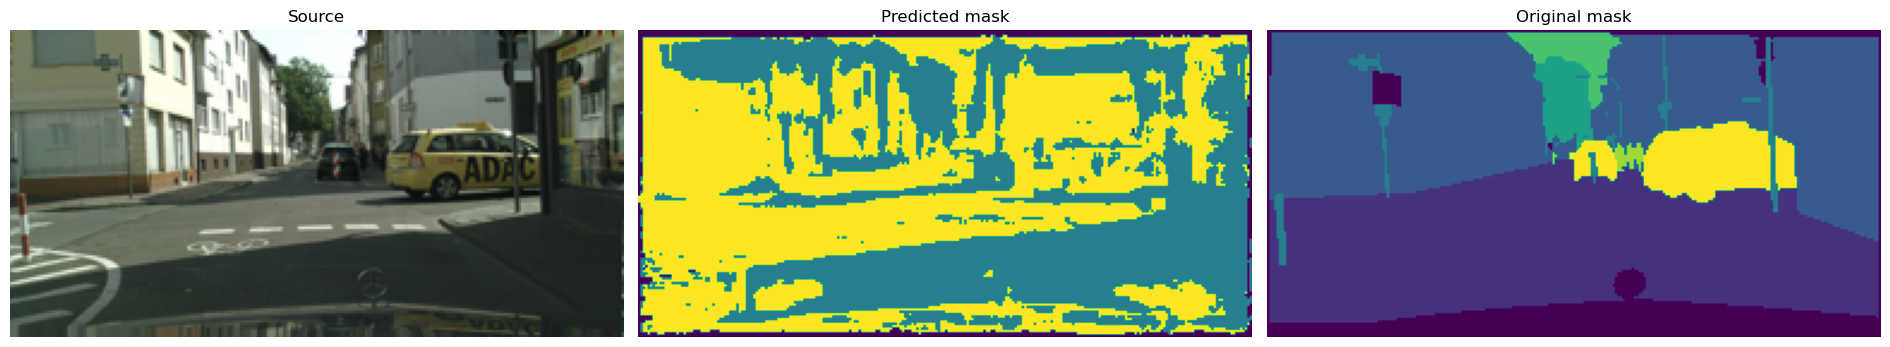

In [26]:
compare_segmentations(test_img, test_mask, predict)

### Sauvegardons les scores

In [27]:
scorer.add_scores(model_name, [iou, dice, training_time, inf_time_valid, inf_time_one])

In [28]:
scorer.show_scores()

IoU      Dice  \
U-Net_baseline                                      0.552171  0.667224   
U-Net_baseline_with_data_augmentation_1             0.564558  0.680571   
U-Net_baseline_with_data_augmentation_2             0.559365  0.674603   
U-Net_baseline_with_data_augmentation_3             0.117844  0.197346   
U-Net_baseline_with_data_augmentation_2_diceLoss    0.631681  0.743959   
U-Net_baseline_with_data_augmentation_2_diceLos...  0.612228  0.728071   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.486711  0.612405   
U-Net_baseline_with_data_augmentation_2_focalLo...  0.454141  0.585703   
U-Net_baseline_with_data_augmentation_2_cceDice...  0.622789  0.738499   
U-Net_baseline_with_data_augmentation_2_cceDice...  0.628407  0.742861   
U-Net-resetnet152_with_data_augmentation_2_dice...  0.722085  0.822108   
U-Net-vgg19_with_data_augmentation_2_diceLoss       0.734644  0.832938   
U-Net-resnext101_with_data_augmentation_2_diceLoss  0.720611  0.820914   
FPN-resnet152_with_data_augmentation_2_diceLoss     0.738715  0.834818   
FPN-efficientnetb7_with_data_augmentation_2_dic...  0.768454  0.858004   
FPN-vgg19_with_data_augmentation_2_diceLoss         0.744457  0.839688   
U-Net-custom_with_data_augmentation_2_diceLoss      0.541770  0.657728   
LinkNet-resnet152_with_data_augmentation_2_dice...  0.707575  0.809275   
LinkNet-efficientnetb7_with_data_augmentation_2...  0.751172  0.844442   

                                                    training_time  \
U-Net_baseline                                         517.575655   
U-Net_baseline_with_data_augmentation_1               1029.694759   
U-Net_baseline_with_data_augmentation_2                714.297488   
U-Net_baseline_with_data_augmentation_3                284.685457   
U-Net_baseline_with_data_augmentation_2_diceLoss       843.582155   
U-Net_baseline_with_data_augmentation_2_diceLos...     697.217847   
U-Net_baseline_with_data_augmentation_2_focalLo...     326.424069   
U-Net_baseline_with_data_augmentation_2_focalLo...     318.810731   
U-Net_baseline_with_data_augmentation_2_cceDice...     899.124581   
U-Net_baseline_with_data_augmentation_2_cceDice...     995.207425   
U-Net-resetnet152_with_data_augmentation_2_dice...    3538.612212   
U-Net-vgg19_with_data_augmentation_2_diceLoss         1932.282903   
U-Net-resnext101_with_data_augmentation_2_diceLoss    3738.743413   
FPN-resnet152_with_data_augmentation_2_diceLoss       4316.767552   
FPN-efficientnetb7_with_data_augmentation_2_dic...    5930.868126   
FPN-vgg19_with_data_augmentation_2_diceLoss           2601.794258   
U-Net-custom_with_data_augmentation_2_diceLoss         820.391873   
LinkNet-resnet152_with_data_augmentation_2_dice...    2433.885920   
LinkNet-efficientnetb7_with_data_augmentation_2...    4191.200948   

                                                    inference_time_500  \
U-Net_baseline                                                1.851263   
U-Net_baseline_with_data_augmentation_1                       2.369722   
U-Net_baseline_with_data_augmentation_2                       2.345822   
U-Net_baseline_with_data_augmentation_3                       2.193978   
U-Net_baseline_with_data_augmentation_2_diceLoss              2.138717   
U-Net_baseline_with_data_augmentation_2_diceLos...            2.189904   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.646039   
U-Net_baseline_with_data_augmentation_2_focalLo...            2.206589   
U-Net_baseline_with_data_augmentation_2_cceDice...            2.216438   
U-Net_baseline_with_data_augmentation_2_cceDice...            2.260605   
U-Net-resetnet152_with_data_augmentation_2_dice...            6.312516   
U-Net-vgg19_with_data_augmentation_2_diceLoss                 3.101655   
U-Net-resnext101_with_data_augmentation_2_diceLoss            5.380407   
FPN-resnet152_with_data_augmentation_2_diceLoss               5.874191   
FPN-efficientnetb7_with_data_augmentation_2_dic...            7.299468   
FPN-vgg19_w

> ### Conclusion <a class="anchor" id="archi_results"></a>
> Sur la base des scores IoU ou Dice, c'est le modèle `FPN-efficientnetb7_with_data_augmentation_2_diceLoss` qui s'en sort le mieux. Mais lorsque l'on regarde le résultat sur des images, ça ne semble pas très cohérent... il se pourrait donc que malgré ses bons résultats, ce modèle ne soit pas exploitable.
>
> Si l'on regarde à la fois les scores et la cohérence des prédictions *(par inspection visuelle)*, il semble que ce soit le modèle `FPN-resnet152_with_data_augmentation_2_diceLoss` qui s'en sorte le mieux.

----
----
----

# Autres Modèles